Danielle Paes Barretto

**VERSION: 30-07-19**

In this notebook the logit will be made for all categories.

The order of the categories in this notebook is given by the order of their mean track popularity (descending).

It will checked for duplicates in 'current_track-next_track' and the duplicates will be eliminated in order to keep 'is_good_sequence' = 1.

Duplicates happened in the larger categories (categories: chill, classical, latin, mood, and roots) because it was necessary split the file with track info in order to be able to generate the one with all possible differences .

Therefore, it is necessary to eliminate the duplicates being careful to keep the ones in which 'is_good_sequence' = 1. For this I'll eliminate the copies in which 'is_good_sequence' = 0, because if there is a current_track-next_track with 'is_good_sequence' = 1 it means that this sequence is present in the category and eliminating this one would make the results in the logistic regression to be wrong.

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import statsmodels.formula.api as smf

import time
TodaysDate = time.strftime("%Y-%m-%d")

# Folders

In [2]:
input_folder = "./data/PREVIOUS_DATA/diff_tracks_050619/"
images_folder = "./data/PREVIOUS_DATA/logit_img/"

# Category Jazz:

## Loading data

In [3]:
file = "df_diff_category_jazz_2019-06-05.csv"

df = pd.read_csv(input_folder+file)

In [4]:
category = file.split('.')[-2].split('_')[-2]
category

'jazz'

## Eliminating duplicates in case they exist

In [5]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2203740 entries, 0 to 2203739
Data columns (total 13 columns):
current_track-next_track    2203740 non-null object
diff_acousticness           2203740 non-null float64
diff_danceability           2203740 non-null float64
diff_energy                 2203740 non-null float64
diff_valence                2203740 non-null float64
diff_tempo                  2203740 non-null float64
diff_instrumentalness       2203740 non-null float64
diff_key                    2203740 non-null float64
diff_mode                   2203740 non-null float64
diff_liveness               2203740 non-null float64
diff_loudness               2203740 non-null float64
diff_speechiness            2203740 non-null float64
is_good_sequence            2203740 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 218.6+ MB


In [6]:
# check for duplicates

len(df['current_track-next_track'].unique())

2203740

In [7]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    2202256
1       1484
Name: is_good_sequence, dtype: int64

In [8]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [9]:
df['is_good_sequence'].value_counts()

0    2202256
1       1484
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [10]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       2.203740e+06       2.203740e+06  2.203740e+06  2.203740e+06   
mean        3.842184e-01       1.737399e-01  2.991519e-01  3.101225e-01   
std         2.899223e-01       1.262417e-01  2.125704e-01  2.199055e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.180000e-01       7.100000e-02  1.210000e-01  1.210000e-01   
50%         3.280000e-01       1.500000e-01  2.620000e-01  2.730000e-01   
75%         6.316000e-01       2.540000e-01  4.470000e-01  4.712000e-01   
max         9.959861e-01       8.892000e-01  9.895200e-01  9.510000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  2.203740e+06           2.203740e+06  2.203740e+06  2.203740e+06   
mean   3.137531e+01           4.311379e-01  4.024266e+00  4.973363e-01   
std    2.484858e+01           3.447673e-01  2.893700e+00  4.999930e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.198400e+01           7.600000e-02  2.000000e+00  0.000000e+00   
50%    2.561300e+01           3.929206e-01  4.000000e+00  0.000000e+00   
75%    4.485000e+01           7.915100e-01  6.000000e+00  1.000000e+00   
max    1.777860e+02           9.740000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   2.203740e+06   2.203740e+06      2.203740e+06      2.203740e+06  
mean    1.139628e-01   6.046924e+00      4.024927e-02      6.734007e-04  
std     1.531827e-01   4.814563e+00      6.634981e-02      2.594123e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     2.060000e-02   2.256000e+00      6.400000e-03      0.000000e+00  
50%     5.120000e-02   4.894000e+00      1.590000e-02      0.000000e+00  
75%     1.450000e-01   8.715000e+00      4.030000e-02      0.000000e+00  
max     9.384000e-01   3.595600e+01      5.117000e-01      1.000000e+00

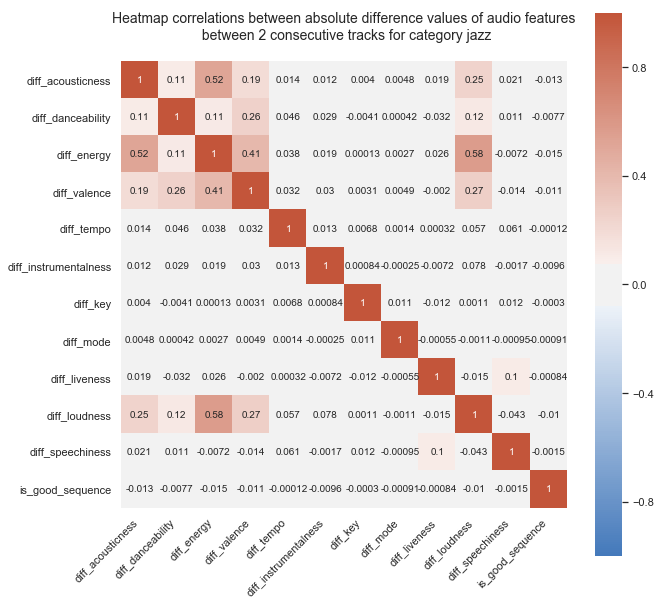

In [11]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [12]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.005351
         Iterations 12


## Summary Logit

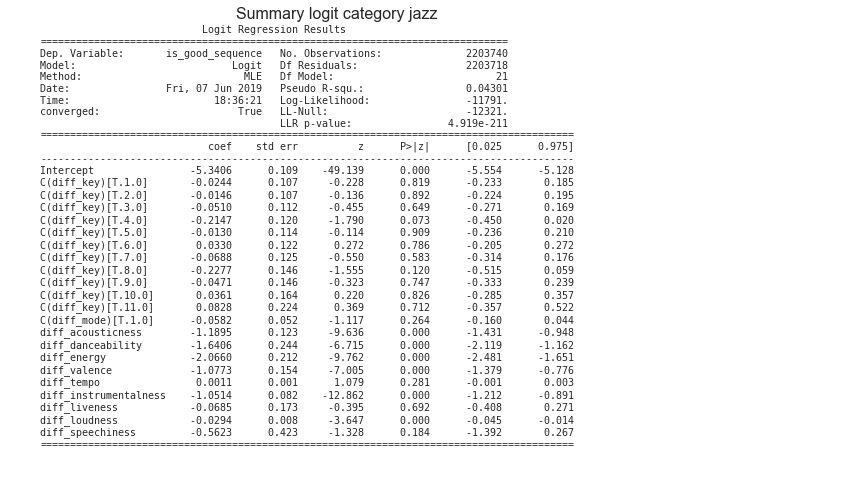

In [13]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

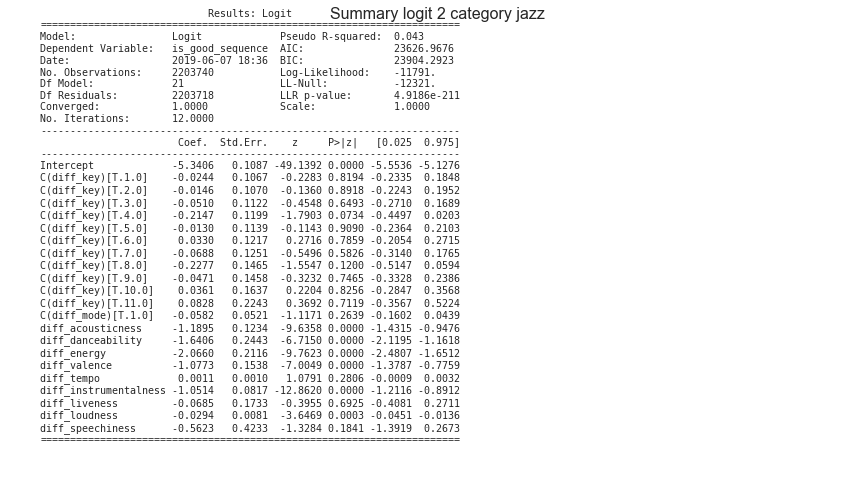

In [14]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [15]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.004793  0.000000e+00  0.003873  0.005931         True
C(key)[T.1.0]     0.975939  8.194260e-01  0.791785  1.202922        False
C(key)[T.2.0]     0.985554  8.918363e-01  0.799085  1.215536        False
C(key)[T.3.0]     0.950248  6.492816e-01  0.762634  1.184016        False
C(key)[T.4.0]     0.806805  7.339802e-02  0.637830  1.020546        False
C(key)[T.5.0]     0.987066  9.090387e-01  0.789500  1.234071        False
C(key)[T.6.0]     1.033598  7.859139e-01  0.814314  1.311934        False
C(key)[T.7.0]     0.933534  5.825950e-01  0.730483  1.193028        False
C(key)[T.8.0]     0.796372  1.200217e-01  0.597660  1.061152        False
C(key)[T.9.0]     0.953982  7.465481e-01  0.716909  1.269452        False
C(key)[T.10.0]    1.036724  8.255853e-01  0.752234  1.428806        False
C(key)[T.11.0]    1.086334  7.119466e-01  0.699952  1.686001        False
C(mode)[T.1.0]    0.943485  2.639457e-01  0.851939  1.044869        False
acousticness      0.304364  5.645686e-22  0.238954  0.387680         True
danceability      0.193861  1.880723e-11  0.120095  0.312937         True
energy            0.126697  1.633431e-22  0.083682  0.191824         True
valence           0.340524  2.472078e-12  0.251908  0.460312         True
tempo             1.001127  2.805603e-01  0.999081  1.003176        False
instrumentalness  0.349450  7.363379e-38  0.297718  0.410172         True
liveness          0.933770  6.924950e-01  0.664889  1.311387        False
loudness          0.971063  2.653837e-04  0.955860  0.986509         True
speechiness       0.569911  1.840565e-01  0.248605  1.306489        False

# Category Kids:

## Loading data

In [16]:
file = "df_diff_category_kids_2019-06-05.csv"

df = pd.read_csv(input_folder+file)

In [17]:
category = file.split('.')[-2].split('_')[-2]
category

'kids'

## Eliminating duplicates in case they exist

In [18]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361802 entries, 0 to 361801
Data columns (total 13 columns):
current_track-next_track    361802 non-null object
diff_acousticness           361802 non-null float64
diff_danceability           361802 non-null float64
diff_energy                 361802 non-null float64
diff_valence                361802 non-null float64
diff_tempo                  361802 non-null float64
diff_instrumentalness       361802 non-null float64
diff_key                    361802 non-null float64
diff_mode                   361802 non-null float64
diff_liveness               361802 non-null float64
diff_loudness               361802 non-null float64
diff_speechiness            361802 non-null float64
is_good_sequence            361802 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 35.9+ MB


In [19]:
# check for duplicates

len(df['current_track-next_track'].unique())

361802

In [20]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    361201
1       601
Name: is_good_sequence, dtype: int64

In [21]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [22]:
df['is_good_sequence'].value_counts()

0    361201
1       601
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [23]:
df.describe()

diff_acousticness  diff_danceability    diff_energy   diff_valence  \
count      361802.000000      361802.000000  361802.000000  361802.000000   
mean            0.416269           0.207788       0.351504       0.321139   
std             0.308033           0.155191       0.253050       0.227395   
min             0.000000           0.000000       0.000000       0.000000   
25%             0.143000           0.083000       0.125420       0.127000   
50%             0.377000           0.176000       0.317800       0.282000   
75%             0.679000           0.301000       0.543000       0.484000   
max             0.995746           0.974000       0.988293       0.987000   

          diff_tempo  diff_instrumentalness       diff_key      diff_mode  \
count  361802.000000          361802.000000  361802.000000  361802.000000   
mean       38.058734               0.417579       3.935628       0.331540   
std        30.118774               0.440442       2.821194       0.470767   
min         0.000000               0.000000       0.000000       0.000000   
25%        14.225000               0.000035       2.000000       0.000000   
50%        30.850000               0.093000       4.000000       0.000000   
75%        54.759000               0.927000       6.000000       1.000000   
max       213.840000               0.985000      11.000000       1.000000   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count  361802.000000  361802.000000     361802.000000     361802.000000  
mean        0.121645       9.747164          0.093518          0.001661  
std         0.153530       8.045002          0.144926          0.040723  
min         0.000000       0.000000          0.000000          0.000000  
25%         0.023000       2.976000          0.012300          0.000000  
50%         0.057300       7.840000          0.034900          0.000000  
75%         0.177000      14.727000          0.104800          0.000000  
max         0.950500      45.858000          0.950000          1.000000

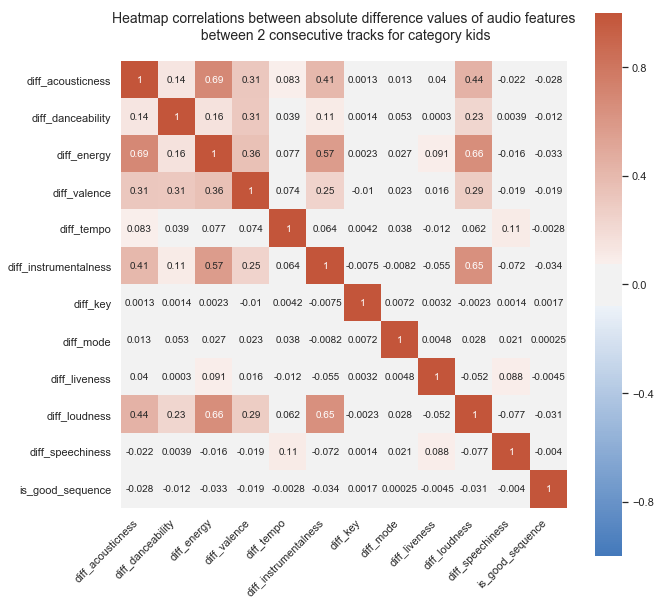

In [24]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [25]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.011165
         Iterations 13


## Summary Logit

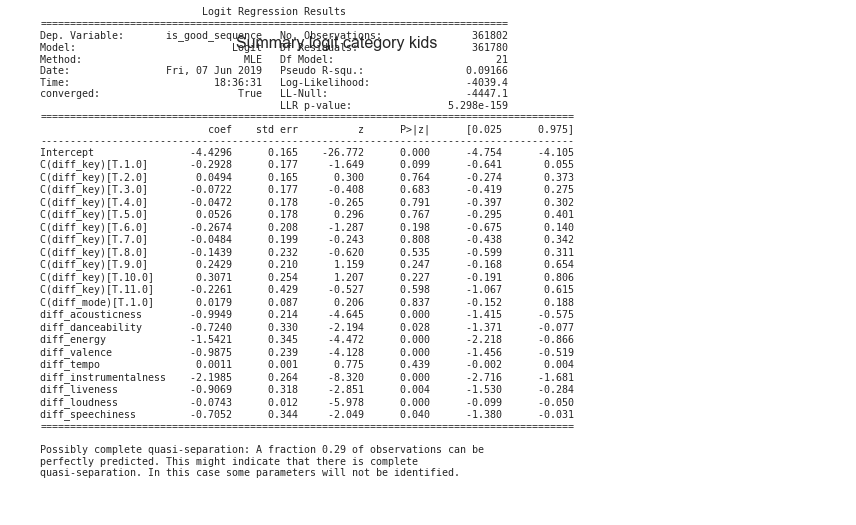

In [26]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

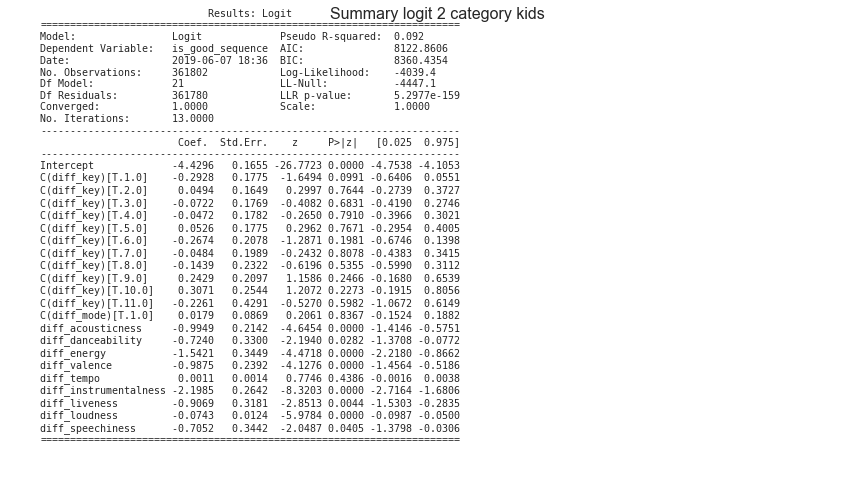

In [27]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [28]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR        p-value      2.5%     97.5%  significant
Intercept         0.011920  6.796924e-158  0.008619  0.016486         True
C(key)[T.1.0]     0.746201   9.906243e-02  0.526954  1.056668        False
C(key)[T.2.0]     1.050671   7.644288e-01  0.760440  1.451672        False
C(key)[T.3.0]     0.930322   6.831389e-01  0.657690  1.315969        False
C(key)[T.4.0]     0.953865   7.909985e-01  0.672631  1.352684        False
C(key)[T.5.0]     1.053989   7.670825e-01  0.744262  1.492610        False
C(key)[T.6.0]     0.765365   1.980621e-01  0.509361  1.150037        False
C(key)[T.7.0]     0.952772   8.078470e-01  0.645156  1.407063        False
C(key)[T.8.0]     0.865997   5.354983e-01  0.549384  1.365078        False
C(key)[T.9.0]     1.274976   2.465994e-01  0.845348  1.922955        False
C(key)[T.10.0]    1.359453   2.273399e-01  0.825746  2.238114        False
C(key)[T.11.0]    0.797616   5.982124e-01  0.343983  1.849484        False
C(mode)[T.1.0]    1.018067   8.367327e-01  0.858651  1.207080        False
acousticness      0.369766   3.393408e-06  0.243014  0.562630         True
danceability      0.484808   2.823791e-02  0.253908  0.925686         True
energy            0.213931   7.757865e-06  0.108826  0.420546         True
valence           0.372515   3.665454e-05  0.233079  0.595364         True
tempo             1.001078   4.385651e-01  0.998352  1.003812        False
instrumentalness  0.110968   8.772380e-17  0.066112  0.186257         True
liveness          0.403780   4.353573e-03  0.216479  0.753138         True
loudness          0.928362   2.253520e-09  0.906011  0.951264         True
speechiness       0.494012   4.048882e-02  0.251619  0.969909         True

# Category Kpop:

## Loading data

In [29]:
file = "df_diff_category_kpop_2019-06-05.csv"

df = pd.read_csv(input_folder+file)

In [30]:
category = file.split('.')[-2].split('_')[-2]
category

'kpop'

## Eliminating duplicates in case they exist

In [31]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124660 entries, 0 to 1124659
Data columns (total 13 columns):
current_track-next_track    1124660 non-null object
diff_acousticness           1124660 non-null float64
diff_danceability           1124660 non-null float64
diff_energy                 1124660 non-null float64
diff_valence                1124660 non-null float64
diff_tempo                  1124660 non-null float64
diff_instrumentalness       1124660 non-null float64
diff_key                    1124660 non-null float64
diff_mode                   1124660 non-null float64
diff_liveness               1124660 non-null float64
diff_loudness               1124660 non-null float64
diff_speechiness            1124660 non-null float64
is_good_sequence            1124660 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 111.5+ MB


In [32]:
# check for duplicates

len(df['current_track-next_track'].unique())

1124660

In [33]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    1123600
1       1060
Name: is_good_sequence, dtype: int64

In [34]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [35]:
df['is_good_sequence'].value_counts()

0    1123600
1       1060
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [36]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       1.124660e+06       1.124660e+06  1.124660e+06  1.124660e+06   
mean        3.465019e-01       1.526970e-01  2.421784e-01  2.544574e-01   
std         2.580652e-01       1.149689e-01  1.771970e-01  1.814406e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.138000e-01       5.900000e-02  9.200000e-02  1.050000e-01   
50%         3.000000e-01       1.290000e-01  2.090000e-01  2.220000e-01   
75%         5.590000e-01       2.230000e-01  3.670000e-01  3.750000e-01   
max         9.767480e-01       7.180000e-01  9.015000e-01  9.265000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  1.124660e+06           1.124660e+06  1.124660e+06  1.124660e+06   
mean   3.107692e+01           2.976876e-03  3.974403e+00  4.289830e-01   
std    2.390277e+01           1.857365e-02  2.850354e+00  4.949311e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.202600e+01           0.000000e+00  2.000000e+00  0.000000e+00   
50%    2.603000e+01           0.000000e+00  4.000000e+00  0.000000e+00   
75%    4.483000e+01           2.515000e-05  6.000000e+00  1.000000e+00   
max    1.605010e+02           2.300000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   1.124660e+06   1.124660e+06      1.124660e+06      1.124660e+06  
mean    1.322324e-01   2.614712e+00      5.295195e-02      9.425071e-04  
std     1.365001e-01   2.171640e+00      6.705622e-02      3.068582e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     3.200000e-02   9.730000e-01      1.010000e-02      0.000000e+00  
50%     8.420000e-02   2.092000e+00      2.750000e-02      0.000000e+00  
75%     1.990000e-01   3.701000e+00      6.620000e-02      0.000000e+00  
max     9.334000e-01   1.886100e+01      4.066000e-01      1.000000e+00

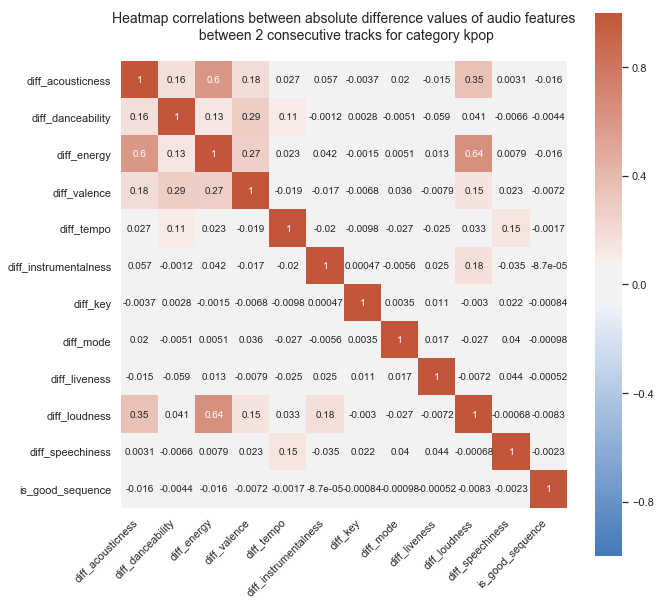

In [37]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [38]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.007313
         Iterations 12


## Summary Logit

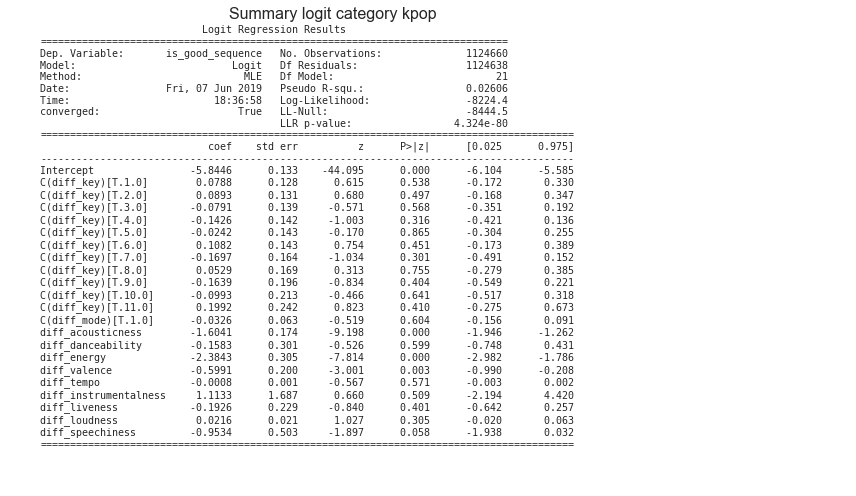

In [39]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

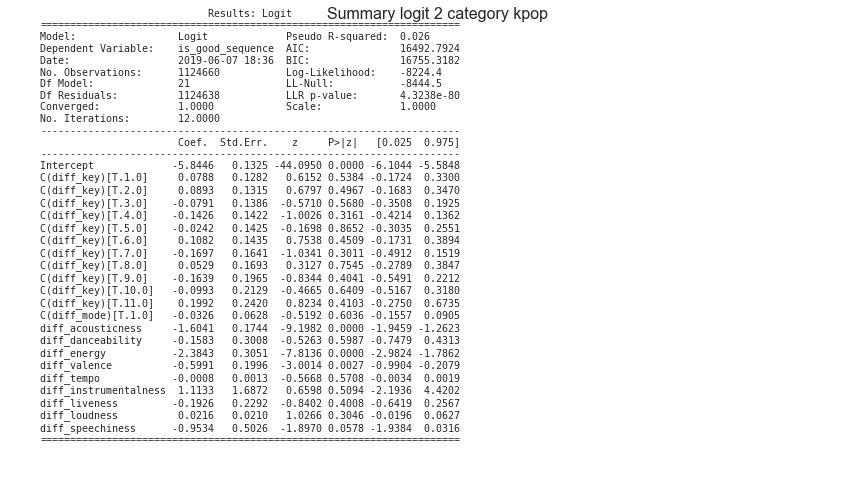

In [40]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [41]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%      97.5%  significant
Intercept         0.002895  0.000000e+00  0.002233   0.003754         True
C(key)[T.1.0]     1.082038  5.384361e-01  0.841678   1.391037        False
C(key)[T.2.0]     1.093460  4.967175e-01  0.845095   1.414817        False
C(key)[T.3.0]     0.923916  5.680078e-01  0.704147   1.212276        False
C(key)[T.4.0]     0.867091  3.160664e-01  0.656123   1.145893        False
C(key)[T.5.0]     0.976096  8.652019e-01  0.738203   1.290652        False
C(key)[T.6.0]     1.114228  4.509414e-01  0.841093   1.476061        False
C(key)[T.7.0]     0.843951  3.010993e-01  0.611873   1.164055        False
C(key)[T.8.0]     1.054362  7.545106e-01  0.756643   1.469226        False
C(key)[T.9.0]     0.848786  4.040735e-01  0.577488   1.247538        False
C(key)[T.10.0]    0.905445  6.408808e-01  0.596497   1.374407        False
C(key)[T.11.0]    1.220471  4.102880e-01  0.759557   1.961074        False
C(mode)[T.1.0]    0.967909  6.035974e-01  0.855782   1.094726        False
acousticness      0.201067  3.641610e-20  0.142855   0.283000         True
danceability      0.853591  5.987003e-01  0.473378   1.539190        False
energy            0.092154  5.556556e-15  0.050673   0.167593         True
valence           0.549293  2.687673e-03  0.371441   0.812303         True
tempo             0.999244  5.708287e-01  0.996635   1.001860        False
instrumentalness  3.044432  5.093513e-01  0.111515  83.114610        False
liveness          0.824798  4.007784e-01  0.526279   1.292644        False
loudness          1.021792  3.046207e-01  0.980590   1.064726        False
speechiness       0.385439  5.782158e-02  0.143940   1.032124        False

# Category Latin:

## Loading data

In [42]:
file = "df_diff_category_latin_2019-06-07.csv"

df = pd.read_csv(input_folder+file)

In [43]:
category = file.split('.')[-2].split('_')[-2]
category

'latin'

## Eliminating duplicates in case they exist

In [44]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8415650 entries, 0 to 8415649
Data columns (total 13 columns):
current_track-next_track    8415650 non-null object
diff_acousticness           8415650 non-null float64
diff_danceability           8415650 non-null float64
diff_energy                 8415650 non-null float64
diff_valence                8415650 non-null float64
diff_tempo                  8415650 non-null float64
diff_instrumentalness       8415650 non-null float64
diff_key                    8415650 non-null float64
diff_mode                   8415650 non-null float64
diff_liveness               8415650 non-null float64
diff_loudness               8415650 non-null float64
diff_speechiness            8415650 non-null float64
is_good_sequence            8415650 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 834.7+ MB


In [45]:
# check for duplicates

len(df['current_track-next_track'].unique())

8317660

In [46]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    8410628
1       5022
Name: is_good_sequence, dtype: int64

In [47]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [48]:
df['is_good_sequence'].value_counts()

0    8312966
1       5020
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [49]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       8.317986e+06       8.317986e+06  8.317986e+06  8.317986e+06   
mean        2.861513e-01       1.502836e-01  1.957960e-01  2.516477e-01   
std         2.244652e-01       1.235044e-01  1.587365e-01  1.913397e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         9.900000e-02       5.600000e-02  7.200000e-02  9.500000e-02   
50%         2.320000e-01       1.200000e-01  1.570000e-01  2.100000e-01   
75%         4.335000e-01       2.140000e-01  2.800000e-01  3.720000e-01   
max         9.958940e-01       9.630000e-01  9.935900e-01  9.760000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  8.317986e+06           8.317986e+06  8.317986e+06  8.317986e+06   
mean   3.401995e+01           6.635331e-02  4.130017e+00  4.948680e-01   
std    2.675853e+01           1.975045e-01  2.977004e+00  4.999737e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.177600e+01           1.920000e-06  2.000000e+00  0.000000e+00   
50%    2.860300e+01           7.220000e-05  4.000000e+00  0.000000e+00   
75%    5.000800e+01           4.710000e-03  6.000000e+00  1.000000e+00   
max    2.338720e+02           9.620000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   8.317986e+06   8.317986e+06      8.317986e+06      8.317986e+06  
mean    1.488938e-01   3.211260e+00      8.420223e-02      6.035115e-04  
std     1.697064e-01   3.199030e+00      1.014075e-01      2.455906e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     3.400000e-02   1.072000e+00      1.640000e-02      0.000000e+00  
50%     8.800000e-02   2.333000e+00      4.760000e-02      0.000000e+00  
75%     2.030000e-01   4.281000e+00      1.192000e-01      0.000000e+00  
max     9.980000e-01   3.559500e+01      9.630000e-01      1.000000e+00

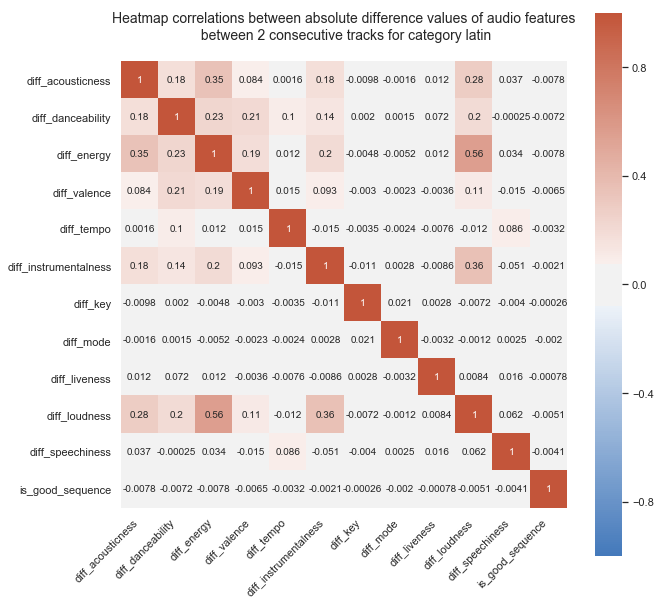

In [50]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [51]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.004980
         Iterations 12


## Summary Logit

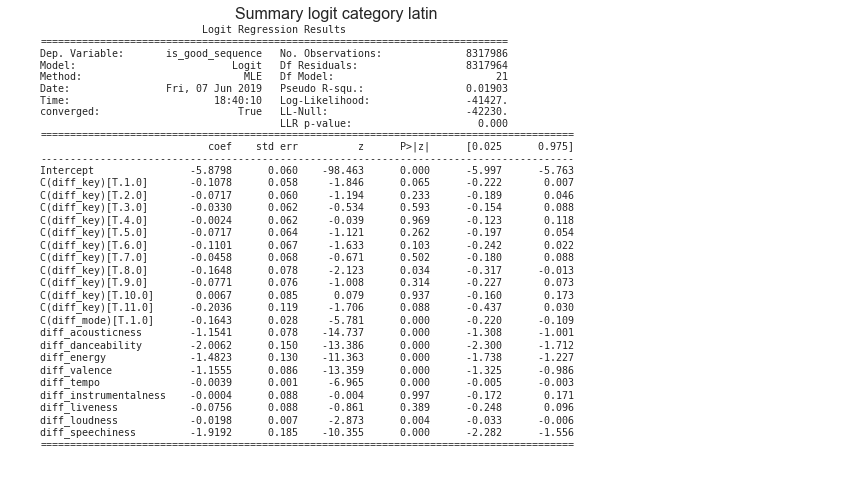

In [52]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

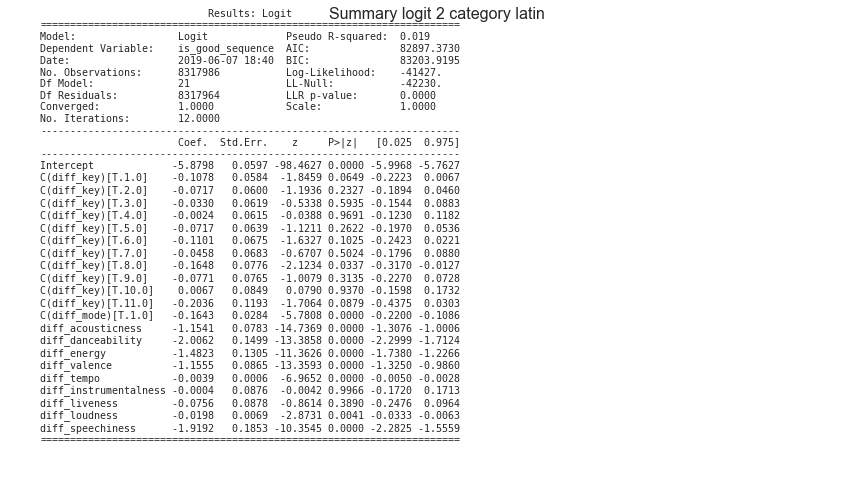

In [53]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [54]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.002795  0.000000e+00  0.002487  0.003142         True
C(key)[T.1.0]     0.897775  6.491203e-02  0.800646  1.006688        False
C(key)[T.2.0]     0.930839  2.326536e-01  0.827490  1.047096        False
C(key)[T.3.0]     0.967497  5.934908e-01  0.856955  1.092299        False
C(key)[T.4.0]     0.997617  9.690611e-01  0.884292  1.125464        False
C(key)[T.5.0]     0.930837  2.622462e-01  0.821215  1.055092        False
C(key)[T.6.0]     0.895713  1.025308e-01  0.784785  1.022321        False
C(key)[T.7.0]     0.955233  5.024023e-01  0.835574  1.092028        False
C(key)[T.8.0]     0.848032  3.372388e-02  0.728338  0.987396         True
C(key)[T.9.0]     0.925822  3.135136e-01  0.796959  1.075522        False
C(key)[T.10.0]    1.006731  9.370475e-01  0.852334  1.189098        False
C(key)[T.11.0]    0.815787  8.793931e-02  0.645673  1.030721        False
C(mode)[T.1.0]    0.848501  7.434306e-09  0.802532  0.897104         True
acousticness      0.315336  3.733314e-49  0.270466  0.367651         True
danceability      0.134502  7.319178e-41  0.100267  0.180427         True
energy            0.227111  6.417685e-30  0.175871  0.293279         True
valence           0.314901  1.045044e-40  0.265797  0.373076         True
tempo             0.996094  3.279257e-12  0.994998  0.997192         True
instrumentalness  0.999630  9.966321e-01  0.841986  1.186791        False
liveness          0.927180  3.889924e-01  0.780649  1.101216        False
loudness          0.980426  4.064648e-03  0.967294  0.993737         True
speechiness       0.146723  3.990632e-25  0.102030  0.210993         True

# Category Metal:

## Loading data

In [55]:
file = "df_diff_category_metal_2019-06-05.csv"

df = pd.read_csv(input_folder+file)

In [56]:
category = file.split('.')[-2].split('_')[-2]
category

'metal'

## Eliminating duplicates in case they exist

In [57]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5127960 entries, 0 to 5127959
Data columns (total 13 columns):
current_track-next_track    5127960 non-null object
diff_acousticness           5127960 non-null float64
diff_danceability           5127960 non-null float64
diff_energy                 5127960 non-null float64
diff_valence                5127960 non-null float64
diff_tempo                  5127960 non-null float64
diff_instrumentalness       5127960 non-null float64
diff_key                    5127960 non-null float64
diff_mode                   5127960 non-null float64
diff_liveness               5127960 non-null float64
diff_loudness               5127960 non-null float64
diff_speechiness            5127960 non-null float64
is_good_sequence            5127960 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 508.6+ MB


In [58]:
# check for duplicates

len(df['current_track-next_track'].unique())

5127960

In [59]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    5125696
1       2264
Name: is_good_sequence, dtype: int64

In [60]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [61]:
df['is_good_sequence'].value_counts()

0    5125696
1       2264
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [62]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       5.127960e+06       5.127960e+06  5.127960e+06  5.127960e+06   
mean        3.171257e-02       1.456252e-01  1.137539e-01  2.084072e-01   
std         1.152056e-01       1.070854e-01  1.428708e-01  1.575552e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.180000e-04       5.800000e-02  2.500000e-02  8.100000e-02   
50%         7.900000e-04       1.250000e-01  6.200000e-02  1.753000e-01   
75%         6.721000e-03       2.150000e-01  1.410000e-01  3.040000e-01   
max         8.430000e-01       7.540000e-01  8.820000e-01  9.410000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  5.127960e+06           5.127960e+06  5.127960e+06  5.127960e+06   
mean   3.399728e+01           3.022021e-01  3.958736e+00  4.873728e-01   
std    2.502705e+01           3.336266e-01  2.849534e+00  4.998406e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.381100e+01           7.910000e-03  2.000000e+00  0.000000e+00   
50%    2.926500e+01           1.260000e-01  4.000000e+00  0.000000e+00   
75%    4.988600e+01           6.166000e-01  6.000000e+00  1.000000e+00   
max    2.027770e+02           9.920000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   5.127960e+06   5.127960e+06      5.127960e+06      5.127960e+06  
mean    1.641408e-01   2.407024e+00      7.452226e-02      4.415011e-04  
std     1.475031e-01   2.432321e+00      1.134962e-01      2.100729e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     4.970000e-02   7.920000e-01      1.980000e-02      0.000000e+00  
50%     1.290000e-01   1.720000e+00      4.590000e-02      0.000000e+00  
75%     2.360000e-01   3.160000e+00      9.080000e-02      0.000000e+00  
max     9.286000e-01   2.074200e+01      9.640000e-01      1.000000e+00

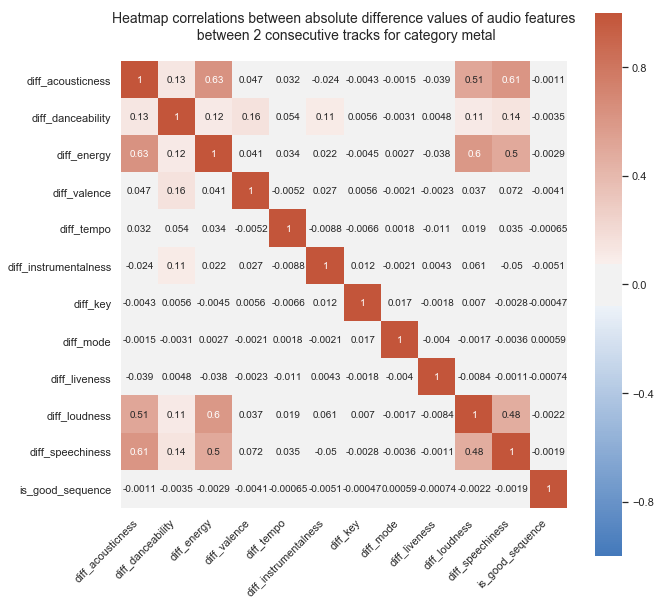

In [63]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [64]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.003820
         Iterations 12


## Summary Logit

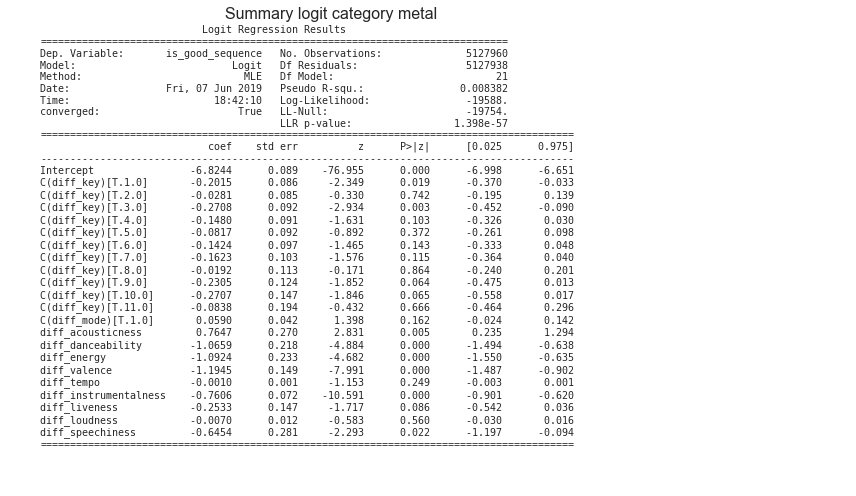

In [65]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

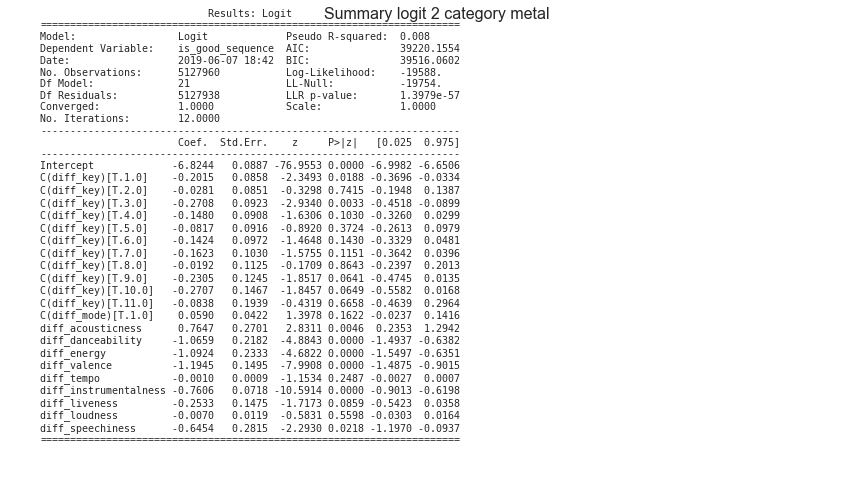

In [66]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [67]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.001087  0.000000e+00  0.000914  0.001293         True
C(key)[T.1.0]     0.817493  1.881090e-02  0.690988  0.967159         True
C(key)[T.2.0]     0.972333  7.415295e-01  0.823017  1.148740        False
C(key)[T.3.0]     0.762743  3.346052e-03  0.636510  0.914010         True
C(key)[T.4.0]     0.862402  1.029731e-01  0.721828  1.030352        False
C(key)[T.5.0]     0.921527  3.724150e-01  0.770052  1.102800        False
C(key)[T.6.0]     0.867277  1.429865e-01  0.716816  1.049319        False
C(key)[T.7.0]     0.850178  1.151311e-01  0.694737  1.040397        False
C(key)[T.8.0]     0.980958  8.643052e-01  0.786844  1.222958        False
C(key)[T.9.0]     0.794122  6.407261e-02  0.622185  1.013572        False
C(key)[T.10.0]    0.762816  6.493020e-02  0.572220  1.016896        False
C(key)[T.11.0]    0.919652  6.658418e-01  0.628830  1.344974        False
C(mode)[T.1.0]    1.060737  1.621649e-01  0.976567  1.152162        False
acousticness      2.148448  4.638428e-03  1.265313  3.647976         True
danceability      0.344401  1.038130e-06  0.224542  0.528241         True
energy            0.335397  2.837806e-06  0.212305  0.529857         True
valence           0.302855  1.340656e-15  0.225940  0.405953         True
tempo             0.999016  2.487285e-01  0.997346  1.000689        False
instrumentalness  0.467395  3.267109e-26  0.406030  0.538034         True
liveness          0.776252  8.592681e-02  0.581381  1.036440        False
loudness          0.993065  5.598248e-01  0.970107  1.016567        False
speechiness       0.524462  2.184844e-02  0.302090  0.910525         True

# Category Mood:

## Loading data

In [68]:
file = "df_diff_category_mood_2019-06-07.csv"

df = pd.read_csv(input_folder+file)

In [69]:
category = file.split('.')[-2].split('_')[-2]
category

'mood'

## Eliminating duplicates in case they exist

In [70]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17215338 entries, 0 to 17215337
Data columns (total 13 columns):
current_track-next_track    17215338 non-null object
diff_acousticness           17215338 non-null float64
diff_danceability           17215338 non-null float64
diff_energy                 17215338 non-null float64
diff_valence                17215338 non-null float64
diff_tempo                  17215338 non-null float64
diff_instrumentalness       17215338 non-null float64
diff_key                    17215338 non-null float64
diff_mode                   17215338 non-null float64
diff_liveness               17215338 non-null float64
diff_loudness               17215338 non-null float64
diff_speechiness            17215338 non-null float64
is_good_sequence            17215338 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.7+ GB


In [71]:
# check for duplicates

len(df['current_track-next_track'].unique())

16941178

In [72]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    17208153
1        7185
Name: is_good_sequence, dtype: int64

In [73]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [74]:
df['is_good_sequence'].value_counts()

0    16934576
1        7180
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [75]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       1.694176e+07       1.694176e+07  1.694176e+07  1.694176e+07   
mean        3.784029e-01       1.675673e-01  2.676948e-01  2.732304e-01   
std         2.856287e-01       1.282186e-01  1.941752e-01  1.987221e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.208000e-01       6.600000e-02  1.080000e-01  1.100000e-01   
50%         3.240000e-01       1.400000e-01  2.310000e-01  2.350000e-01   
75%         6.130000e-01       2.410000e-01  3.950000e-01  4.020000e-01   
max         9.959895e-01       9.019000e-01  9.979300e-01  9.633000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  1.694176e+07           1.694176e+07  1.694176e+07  1.694176e+07   
mean   3.195219e+01           1.532413e-01  4.074436e+00  4.223473e-01   
std    2.459203e+01           2.912210e-01  2.925506e+00  4.939333e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.235900e+01           2.540000e-05  2.000000e+00  0.000000e+00   
50%    2.650900e+01           1.648775e-03  4.000000e+00  0.000000e+00   
75%    4.607600e+01           1.060000e-01  6.000000e+00  1.000000e+00   
max    1.945890e+02           9.900000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   1.694176e+07   1.694176e+07      1.694176e+07      1.694176e+07  
mean    1.062265e-01   4.607777e+00      4.876730e-02      4.238049e-04  
std     1.342213e-01   4.539078e+00      7.622531e-02      2.058216e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     2.000000e-02   1.492000e+00      6.700000e-03      0.000000e+00  
50%     5.140000e-02   3.288000e+00      1.800000e-02      0.000000e+00  
75%     1.430000e-01   6.143000e+00      5.240000e-02      0.000000e+00  
max     9.608000e-01   3.887600e+01      5.471000e-01      1.000000e+00

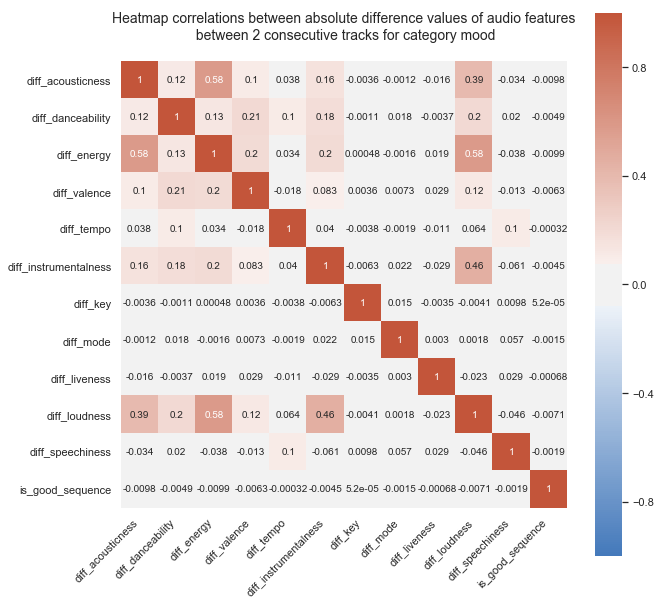

In [76]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [77]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.003617
         Iterations 13


## Summary Logit

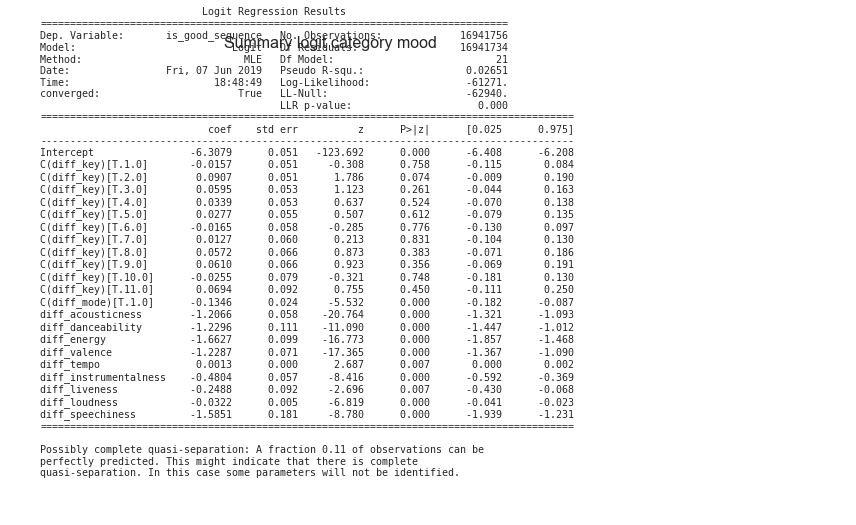

In [78]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

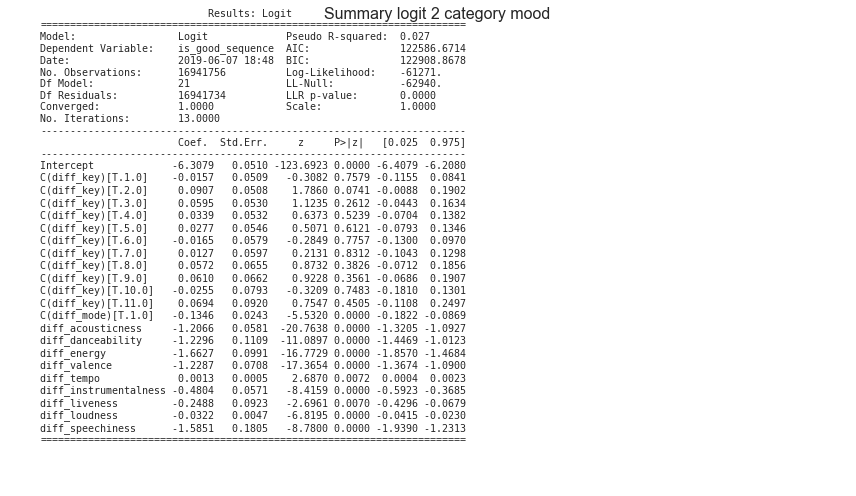

In [79]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [80]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.001822  0.000000e+00  0.001648  0.002013         True
C(key)[T.1.0]     0.984427  7.579079e-01  0.890922  1.087746        False
C(key)[T.2.0]     1.094928  7.409368e-02  0.991207  1.209502        False
C(key)[T.3.0]     1.061328  2.612399e-01  0.956650  1.177460        False
C(key)[T.4.0]     1.034504  5.239080e-01  0.932024  1.148251        False
C(key)[T.5.0]     1.028054  6.120629e-01  0.923797  1.144077        False
C(key)[T.6.0]     0.983639  7.756975e-01  0.878123  1.101834        False
C(key)[T.7.0]     1.012808  8.312264e-01  0.900947  1.138557        False
C(key)[T.8.0]     1.058882  3.825669e-01  0.931266  1.203987        False
C(key)[T.9.0]     1.062951  3.561370e-01  0.933679  1.210122        False
C(key)[T.10.0]    0.974858  7.482795e-01  0.834452  1.138890        False
C(key)[T.11.0]    1.071869  4.504521e-01  0.895075  1.283584        False
C(mode)[T.1.0]    0.874108  3.165736e-08  0.833416  0.916786         True
acousticness      0.299211  9.200928e-96  0.267001  0.335306         True
danceability      0.292410  1.407278e-28  0.235295  0.363388         True
energy            0.189626  3.849325e-63  0.156142  0.230291         True
valence           0.292668  1.507605e-67  0.254769  0.336204         True
tempo             1.001310  7.209261e-03  1.000354  1.002267         True
instrumentalness  0.618547  3.900111e-17  0.553077  0.691767         True
liveness          0.779772  7.015422e-03  0.650778  0.934335         True
loudness          0.968294  9.137259e-12  0.959368  0.977302         True
speechiness       0.204923  1.635150e-18  0.143852  0.291920         True

# Category Party:

## Loading data

In [81]:
file = "df_diff_category_party_2019-06-05.csv"

df = pd.read_csv(input_folder+file)

In [82]:
category = file.split('.')[-2].split('_')[-2]
category

'party'

## Eliminating duplicates in case they exist

In [83]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7753440 entries, 0 to 7753439
Data columns (total 13 columns):
current_track-next_track    7753440 non-null object
diff_acousticness           7753440 non-null float64
diff_danceability           7753440 non-null float64
diff_energy                 7753440 non-null float64
diff_valence                7753440 non-null float64
diff_tempo                  7753440 non-null float64
diff_instrumentalness       7753440 non-null float64
diff_key                    7753440 non-null float64
diff_mode                   7753440 non-null float64
diff_liveness               7753440 non-null float64
diff_loudness               7753440 non-null float64
diff_speechiness            7753440 non-null float64
is_good_sequence            7753440 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 769.0+ MB


In [84]:
# check for duplicates

len(df['current_track-next_track'].unique())

7753440

In [85]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    7750656
1       2784
Name: is_good_sequence, dtype: int64

In [86]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [87]:
df['is_good_sequence'].value_counts()

0    7750656
1       2784
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [88]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       7.753440e+06       7.753440e+06  7.753440e+06  7.753440e+06   
mean        1.822162e-01       1.464928e-01  1.719909e-01  2.616787e-01   
std         1.902782e-01       1.131386e-01  1.349251e-01  1.897255e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         3.521575e-02       5.700000e-02  6.500000e-02  1.060000e-01   
50%         1.136000e-01       1.220000e-01  1.410000e-01  2.260000e-01   
75%         2.701000e-01       2.100000e-01  2.490000e-01  3.840000e-01   
max         9.549891e-01       7.780000e-01  8.660000e-01  9.469000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  7.753440e+06           7.753440e+06  7.753440e+06  7.753440e+06   
mean   2.462054e+01           1.374667e-01  4.188224e+00  4.878645e-01   
std    2.127870e+01           2.623273e-01  3.012511e+00  4.998527e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    7.942000e+00           1.610000e-05  2.000000e+00  0.000000e+00   
50%    1.997600e+01           1.778820e-03  4.000000e+00  0.000000e+00   
75%    3.480300e+01           1.019351e-01  6.000000e+00  1.000000e+00   
max    1.509630e+02           9.470000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   7.753440e+06   7.753440e+06      7.753440e+06      7.753440e+06  
mean    1.431981e-01   2.801436e+00      8.173372e-02      3.590664e-04  
std     1.462881e-01   2.361580e+00      9.225490e-02      1.894565e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     3.500000e-02   1.023000e+00      1.500000e-02      0.000000e+00  
50%     9.200000e-02   2.203000e+00      4.250000e-02      0.000000e+00  
75%     2.140000e-01   3.923000e+00      1.206000e-01      0.000000e+00  
max     9.602000e-01   2.010000e+01      5.418000e-01      1.000000e+00

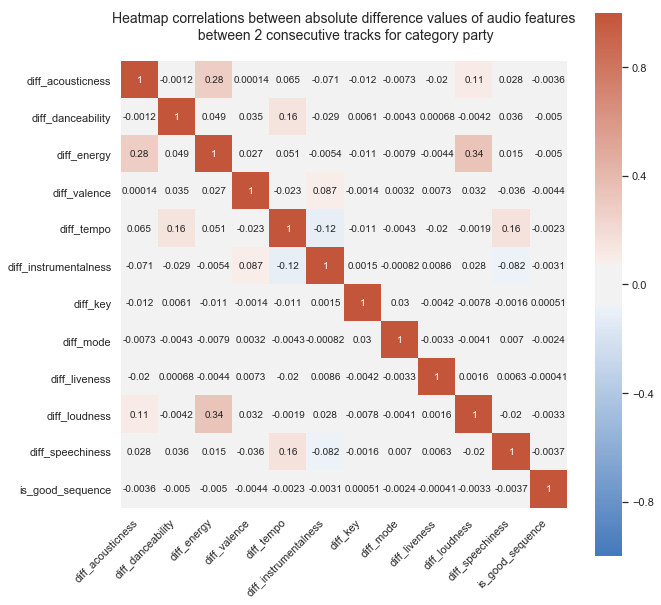

In [89]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [90]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.003149
         Iterations 13


## Summary Logit

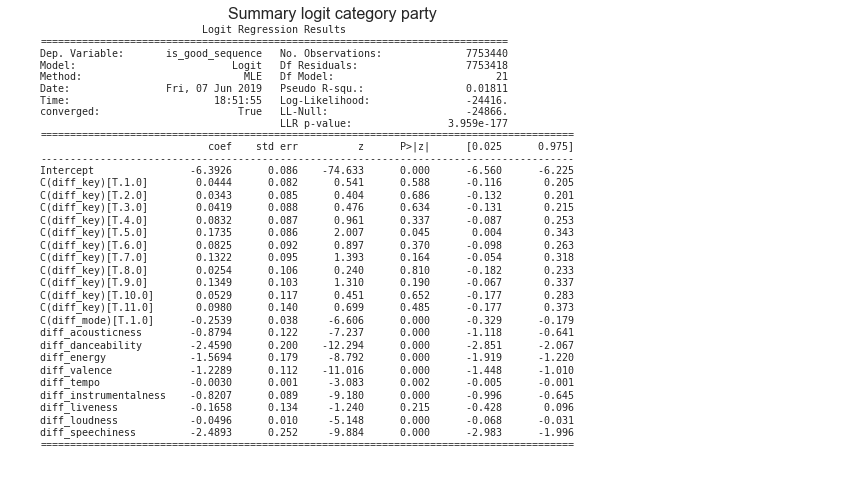

In [91]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

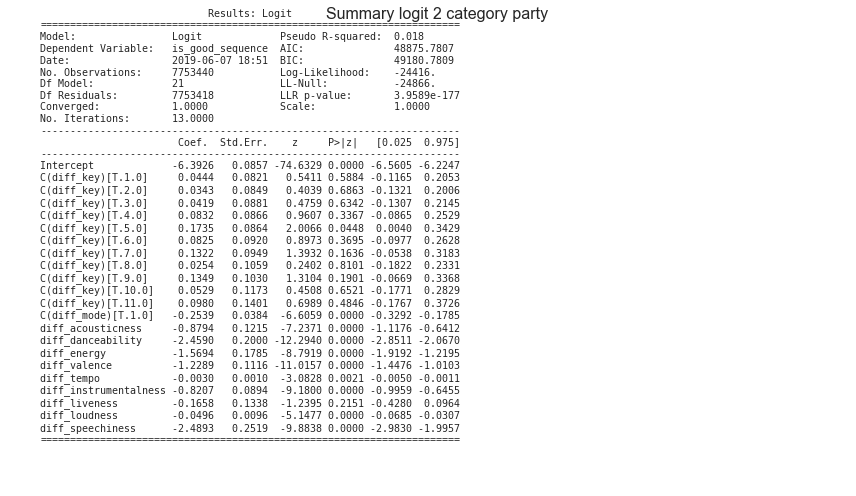

In [92]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [93]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.001674  0.000000e+00  0.001415  0.001980         True
C(key)[T.1.0]     1.045413  5.884254e-01  0.890074  1.227862        False
C(key)[T.2.0]     1.034868  6.863230e-01  0.876284  1.222153        False
C(key)[T.3.0]     1.042798  6.341513e-01  0.877491  1.239247        False
C(key)[T.4.0]     1.086760  3.367021e-01  0.917099  1.287808        False
C(key)[T.5.0]     1.189412  4.479539e-02  1.004037  1.409013         True
C(key)[T.6.0]     1.086046  3.695362e-01  0.906878  1.300612        False
C(key)[T.7.0]     1.141378  1.635671e-01  0.947623  1.374747        False
C(key)[T.8.0]     1.025776  8.101436e-01  0.833456  1.262473        False
C(key)[T.9.0]     1.144477  1.900756e-01  0.935288  1.400453        False
C(key)[T.10.0]    1.054328  6.521011e-01  0.837710  1.326960        False
C(key)[T.11.0]    1.102908  4.846100e-01  0.838002  1.451555        False
C(mode)[T.1.0]    0.775802  3.951356e-11  0.719515  0.836492         True
acousticness      0.415030  4.585477e-13  0.327074  0.526638         True
danceability      0.085517  9.758534e-35  0.057783  0.126564         True
energy            0.208179  1.471066e-18  0.146722  0.295377         True
valence           0.292609  3.209310e-28  0.235140  0.364123         True
tempo             0.996957  2.050302e-03  0.995027  0.998891         True
instrumentalness  0.440115  4.309337e-20  0.369374  0.524403         True
liveness          0.847218  2.151497e-01  0.651838  1.101160        False
loudness          0.951607  2.636569e-07  0.933803  0.969750         True
speechiness       0.082964  4.892549e-23  0.050641  0.135917         True

# Category Pop:

## Loading data

In [94]:
file = "df_diff_category_pop_2019-06-05.csv"

df = pd.read_csv(input_folder+file)

In [95]:
category = file.split('.')[-2].split('_')[-2]
category

'pop'

## Eliminating duplicates in case they exist

In [96]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6083622 entries, 0 to 6083621
Data columns (total 13 columns):
current_track-next_track    6083622 non-null object
diff_acousticness           6083622 non-null float64
diff_danceability           6083622 non-null float64
diff_energy                 6083622 non-null float64
diff_valence                6083622 non-null float64
diff_tempo                  6083622 non-null float64
diff_instrumentalness       6083622 non-null float64
diff_key                    6083622 non-null float64
diff_mode                   6083622 non-null float64
diff_liveness               6083622 non-null float64
diff_loudness               6083622 non-null float64
diff_speechiness            6083622 non-null float64
is_good_sequence            6083622 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 603.4+ MB


In [97]:
# check for duplicates

len(df['current_track-next_track'].unique())

6083622

In [98]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    6081156
1       2466
Name: is_good_sequence, dtype: int64

In [99]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [100]:
df['is_good_sequence'].value_counts()

0    6081156
1       2466
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [101]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       6.083622e+06       6.083622e+06  6.083622e+06  6.083622e+06   
mean        3.008416e-01       1.562101e-01  2.209575e-01  2.600304e-01   
std         2.503048e-01       1.190273e-01  1.646359e-01  1.869409e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         8.590000e-02       6.200000e-02  8.800000e-02  1.060000e-01   
50%         2.331500e-01       1.310000e-01  1.870000e-01  2.260000e-01   
75%         4.739000e-01       2.250000e-01  3.224000e-01  3.820000e-01   
max         9.919657e-01       8.250000e-01  9.365000e-01  9.405000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  6.083622e+06           6.083622e+06  6.083622e+06  6.083622e+06   
mean   3.101601e+01           3.476899e-02  4.175597e+00  4.678923e-01   
std    2.430584e+01           1.266645e-01  3.004015e+00  4.989681e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.188200e+01           0.000000e+00  2.000000e+00  0.000000e+00   
50%    2.530100e+01           3.990000e-05  4.000000e+00  0.000000e+00   
75%    4.492200e+01           1.620000e-03  6.000000e+00  1.000000e+00   
max    1.573510e+02           9.180000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   6.083622e+06   6.083622e+06      6.083622e+06      6.083622e+06  
mean    1.124465e-01   2.790424e+00      6.340866e-02      4.053506e-04  
std     1.320844e-01   2.368938e+00      8.169389e-02      2.012924e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     2.500000e-02   1.015000e+00      1.060000e-02      0.000000e+00  
50%     6.160000e-02   2.190000e+00      2.940000e-02      0.000000e+00  
75%     1.550000e-01   3.915000e+00      8.190000e-02      0.000000e+00  
max     9.718000e-01   1.938400e+01      4.909000e-01      1.000000e+00

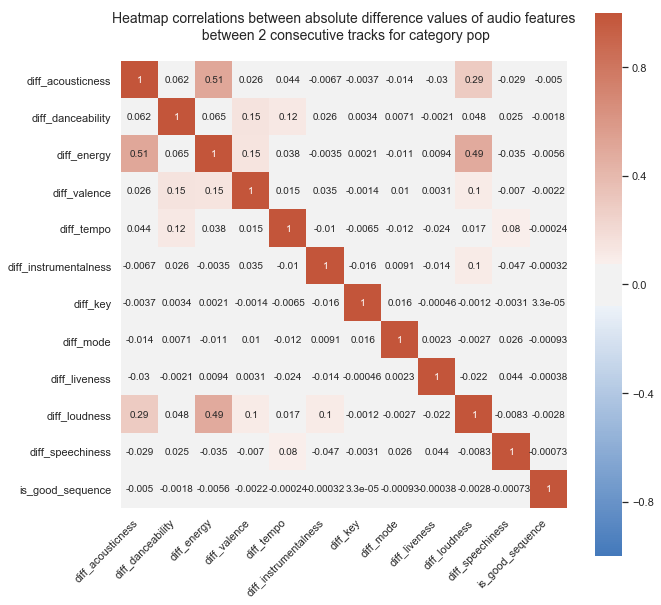

In [102]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [103]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.003547
         Iterations 12


## Summary Logit

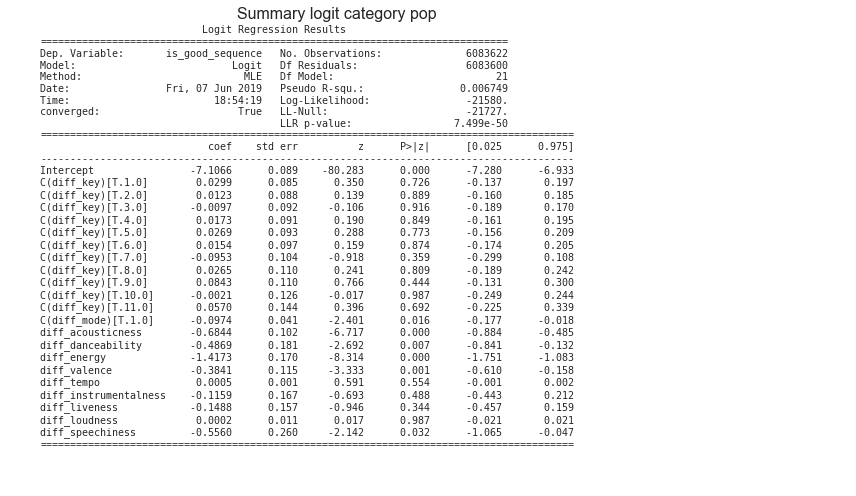

In [104]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

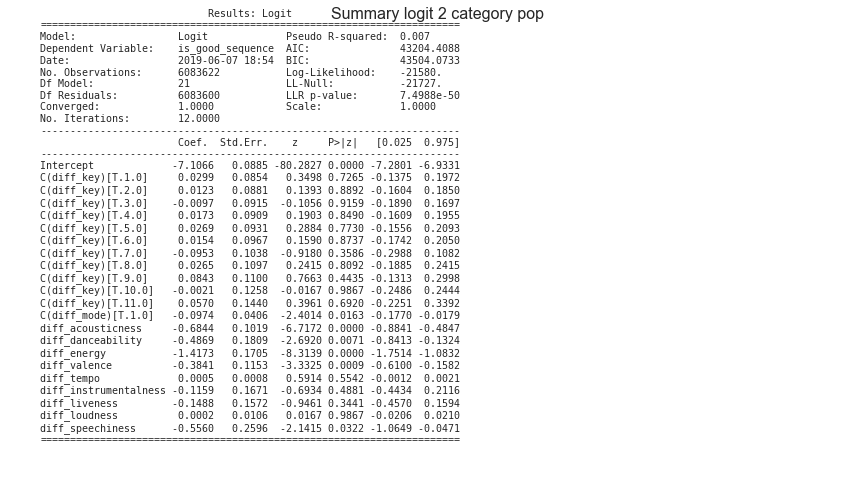

In [105]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [106]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.000820  0.000000e+00  0.000689  0.000975         True
C(key)[T.1.0]     1.030313  7.264855e-01  0.871571  1.217966        False
C(key)[T.2.0]     1.012350  8.892238e-01  0.851770  1.203203        False
C(key)[T.3.0]     0.990380  9.158675e-01  0.827771  1.184931        False
C(key)[T.4.0]     1.017451  8.490494e-01  0.851417  1.215863        False
C(key)[T.5.0]     1.027219  7.730199e-01  0.855872  1.232869        False
C(key)[T.6.0]     1.015494  8.737012e-01  0.840124  1.227473        False
C(key)[T.7.0]     0.909080  3.586249e-01  0.741678  1.114267        False
C(key)[T.8.0]     1.026846  8.091832e-01  0.828179  1.273169        False
C(key)[T.9.0]     1.087928  4.435033e-01  0.876974  1.349628        False
C(key)[T.10.0]    0.997904  9.866900e-01  0.779908  1.276834        False
C(key)[T.11.0]    1.058681  6.920104e-01  0.798423  1.403773        False
C(mode)[T.1.0]    0.907156  1.633461e-02  0.837804  0.982249         True
acousticness      0.504397  1.852535e-11  0.413092  0.615884         True
danceability      0.614554  7.102219e-03  0.431139  0.875996         True
energy            0.242367  9.258197e-17  0.173527  0.338517         True
valence           0.681073  8.606613e-04  0.543362  0.853686         True
tempo             1.000498  5.542221e-01  0.998849  1.002149        False
instrumentalness  0.890603  4.880879e-01  0.641876  1.235710        False
liveness          0.861771  3.441175e-01  0.633202  1.172847        False
loudness          1.000177  9.866532e-01  0.979601  1.021187        False
speechiness       0.573483  3.223145e-02  0.344758  0.953952         True

# Category Punk:

## Loading data

In [107]:
file = "df_diff_category_punk_2019-06-05.csv"

df = pd.read_csv(input_folder+file)

In [108]:
category = file.split('.')[-2].split('_')[-2]
category

'punk'

## Eliminating duplicates in case they exist

In [109]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799622 entries, 0 to 1799621
Data columns (total 13 columns):
current_track-next_track    1799622 non-null object
diff_acousticness           1799622 non-null float64
diff_danceability           1799622 non-null float64
diff_energy                 1799622 non-null float64
diff_valence                1799622 non-null float64
diff_tempo                  1799622 non-null float64
diff_instrumentalness       1799622 non-null float64
diff_key                    1799622 non-null float64
diff_mode                   1799622 non-null float64
diff_liveness               1799622 non-null float64
diff_loudness               1799622 non-null float64
diff_speechiness            1799622 non-null float64
is_good_sequence            1799622 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 178.5+ MB


In [110]:
# check for duplicates

len(df['current_track-next_track'].unique())

1799622

In [111]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    1798281
1       1341
Name: is_good_sequence, dtype: int64

In [112]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [113]:
df['is_good_sequence'].value_counts()

0    1798281
1       1341
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [114]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       1.799622e+06       1.799622e+06  1.799622e+06  1.799622e+06   
mean        1.213554e-01       1.459637e-01  1.426162e-01  2.571158e-01   
std         2.125938e-01       1.092080e-01  1.475324e-01  1.844321e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.440000e-03       5.800000e-02  3.600000e-02  1.060000e-01   
50%         1.466000e-02       1.240000e-01  8.900000e-02  2.240000e-01   
75%         1.229428e-01       2.110000e-01  1.990000e-01  3.760000e-01   
max         9.849983e-01       7.520000e-01  8.900000e-01  9.422000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  1.799622e+06           1.799622e+06  1.799622e+06  1.799622e+06   
mean   3.738999e+01           1.205062e-01  4.018597e+00  3.963110e-01   
std    2.663373e+01           2.373146e-01  2.896597e+00  4.891306e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.497700e+01           3.423000e-05  2.000000e+00  0.000000e+00   
50%    3.282900e+01           1.848920e-03  4.000000e+00  0.000000e+00   
75%    5.601700e+01           8.275742e-02  6.000000e+00  1.000000e+00   
max    1.522110e+02           9.740000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   1.799622e+06   1.799622e+06      1.799622e+06      1.799622e+06  
mean    1.694999e-01   2.660784e+00      5.539349e-02      7.451565e-04  
std     1.553767e-01   2.497725e+00      6.140704e-02      2.728739e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     5.000000e-02   8.840000e-01      1.500000e-02      0.000000e+00  
50%     1.290000e-01   1.957000e+00      3.530000e-02      0.000000e+00  
75%     2.413000e-01   3.688000e+00      7.270000e-02      0.000000e+00  
max     9.311000e-01   2.672800e+01      5.258000e-01      1.000000e+00

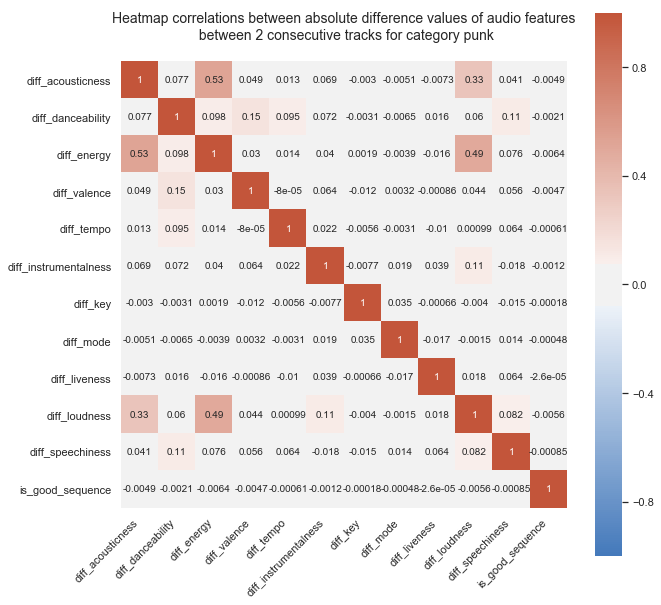

In [115]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [116]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.006068
         Iterations 12


## Summary Logit

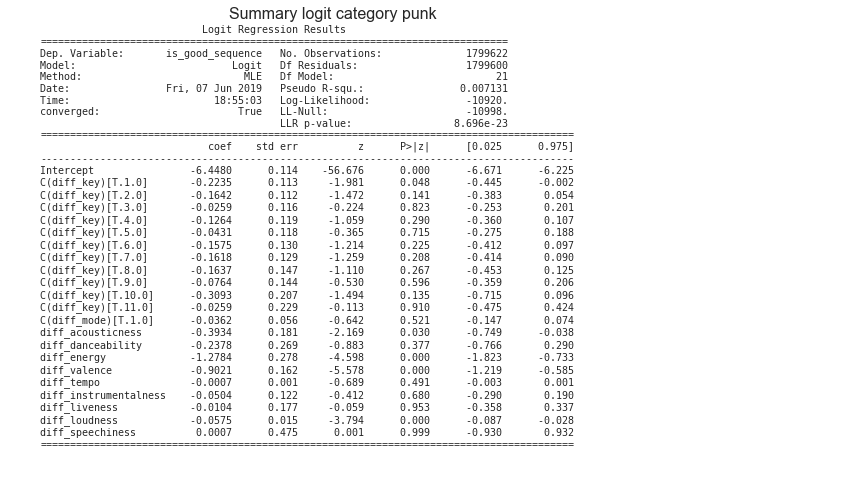

In [117]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

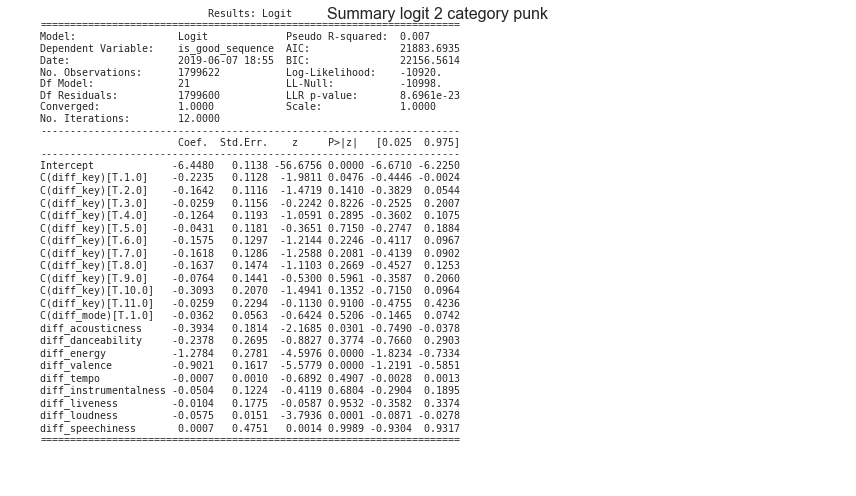

In [118]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [119]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.001584  0.000000e+00  0.001267  0.001979         True
C(key)[T.1.0]     0.799707  4.757453e-02  0.641061  0.997613         True
C(key)[T.2.0]     0.848563  1.410354e-01  0.681904  1.055953        False
C(key)[T.3.0]     0.974415  8.226147e-01  0.776849  1.222226        False
C(key)[T.4.0]     0.881294  2.895480e-01  0.697530  1.113470        False
C(key)[T.5.0]     0.957787  7.150464e-01  0.759821  1.207332        False
C(key)[T.6.0]     0.854286  2.246105e-01  0.662540  1.101526        False
C(key)[T.7.0]     0.850569  2.081177e-01  0.661094  1.094349        False
C(key)[T.8.0]     0.849000  2.668873e-01  0.635927  1.133466        False
C(key)[T.9.0]     0.926488  5.960892e-01  0.698584  1.228742        False
C(key)[T.10.0]    0.733985  1.351544e-01  0.489207  1.101238        False
C(key)[T.11.0]    0.974413  9.100262e-01  0.621594  1.527494        False
C(mode)[T.1.0]    0.964480  5.206007e-01  0.863720  1.076994        False
acousticness      0.674745  3.011767e-02  0.472839  0.962867         True
danceability      0.788325  3.774032e-01  0.464884  1.336797        False
energy            0.278475  4.274208e-06  0.161471  0.480259         True
valence           0.405700  2.434667e-08  0.295485  0.557024         True
tempo             0.999284  4.907095e-01  0.997249  1.001322        False
instrumentalness  0.950822  6.804404e-01  0.747961  1.208703        False
liveness          0.989633  9.531722e-01  0.698901  1.401304        False
loudness          0.944159  1.485041e-04  0.916542  0.972609         True
speechiness       1.000656  9.988984e-01  0.394386  2.538917        False

# Category Reggae:

## Loading data

In [120]:
file = "df_diff_category_reggae_2019-06-05.csv"

df = pd.read_csv(input_folder+file)

In [121]:
category = file.split('.')[-2].split('_')[-2]
category

'reggae'

## Eliminating duplicates in case they exist

In [122]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999000 entries, 0 to 998999
Data columns (total 13 columns):
current_track-next_track    999000 non-null object
diff_acousticness           999000 non-null float64
diff_danceability           999000 non-null float64
diff_energy                 999000 non-null float64
diff_valence                999000 non-null float64
diff_tempo                  999000 non-null float64
diff_instrumentalness       999000 non-null float64
diff_key                    999000 non-null float64
diff_mode                   999000 non-null float64
diff_liveness               999000 non-null float64
diff_loudness               999000 non-null float64
diff_speechiness            999000 non-null float64
is_good_sequence            999000 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 99.1+ MB


In [123]:
# check for duplicates

len(df['current_track-next_track'].unique())

999000

In [124]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    998001
1       999
Name: is_good_sequence, dtype: int64

In [125]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [126]:
df['is_good_sequence'].value_counts()

0    998001
1       999
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [127]:
df.describe()

diff_acousticness  diff_danceability    diff_energy   diff_valence  \
count      999000.000000      999000.000000  999000.000000  999000.000000   
mean            0.193481           0.130864       0.182442       0.214432   
std             0.185198           0.098081       0.133249       0.162258   
min             0.000000           0.000000       0.000000       0.000000   
25%             0.049000           0.052000       0.074000       0.083000   
50%             0.132000           0.111000       0.157000       0.179000   
75%             0.285950           0.190000       0.266000       0.315000   
max             0.969983           0.636000       0.799000       0.844000   

          diff_tempo  diff_instrumentalness       diff_key      diff_mode  \
count  999000.000000          999000.000000  999000.000000  999000.000000   
mean       35.833581               0.087880       4.089906       0.492555   
std        27.561782               0.222733       2.973586       0.499945   
min         0.000000               0.000000       0.000000       0.000000   
25%        13.399000               0.000002       2.000000       0.000000   
50%        29.676000               0.000196       4.000000       0.000000   
75%        52.374000               0.020645       6.000000       1.000000   
max       157.290000               0.950000      11.000000       1.000000   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count  999000.000000  999000.000000     999000.000000     999000.000000  
mean        0.117767       3.146628          0.117484          0.001000  
std         0.128648       2.557395          0.099818          0.031607  
min         0.000000       0.000000          0.000000          0.000000  
25%         0.028000       1.173000          0.032600          0.000000  
50%         0.070000       2.532000          0.090200          0.000000  
75%         0.173000       4.481000          0.184500          0.000000  
max         0.946300      20.845000          0.488900          1.000000

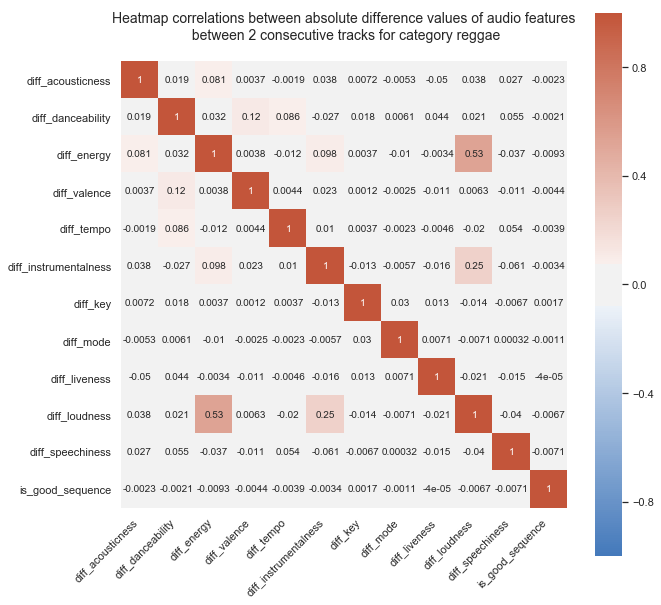

In [128]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [129]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.007798
         Iterations 12


## Summary Logit

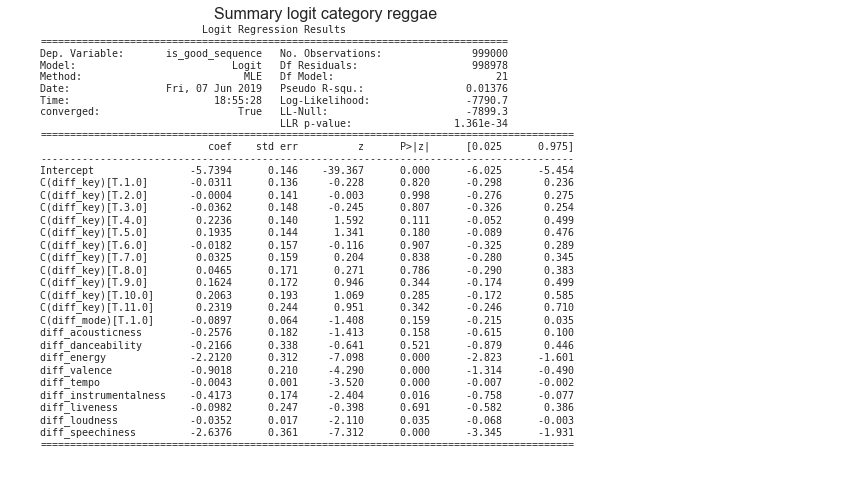

In [130]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

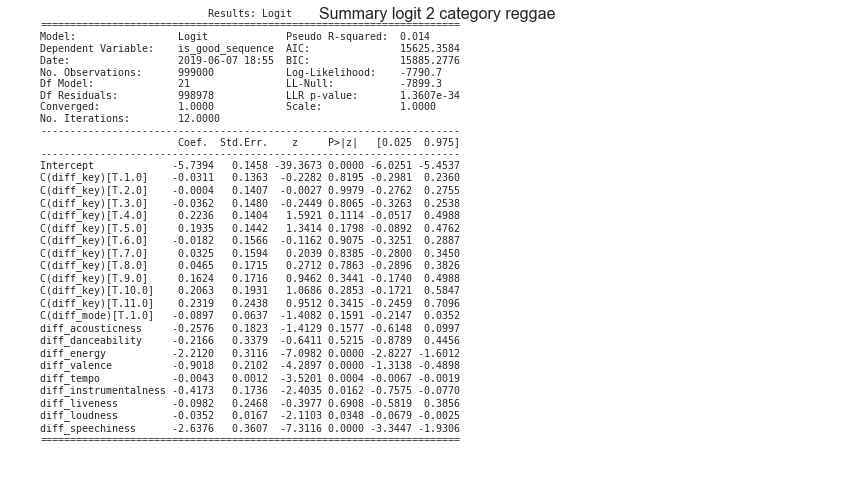

In [131]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [132]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.003217  0.000000e+00  0.002417  0.004281         True
C(key)[T.1.0]     0.969392  8.195280e-01  0.742203  1.266124        False
C(key)[T.2.0]     0.999626  9.978820e-01  0.758653  1.317141        False
C(key)[T.3.0]     0.964407  8.065293e-01  0.721602  1.288911        False
C(key)[T.4.0]     1.250554  1.113673e-01  0.949647  1.646807        False
C(key)[T.5.0]     1.213453  1.797833e-01  0.914653  1.609867        False
C(key)[T.6.0]     0.981967  9.074795e-01  0.722462  1.334686        False
C(key)[T.7.0]     1.033037  8.384517e-01  0.755810  1.411949        False
C(key)[T.8.0]     1.047595  7.862699e-01  0.748572  1.466065        False
C(key)[T.9.0]     1.176315  3.440511e-01  0.840309  1.646678        False
C(key)[T.10.0]    1.229113  2.852583e-01  0.841908  1.794399        False
C(key)[T.11.0]    1.260947  3.415175e-01  0.781993  2.033251        False
C(mode)[T.1.0]    0.914161  1.590806e-01  0.806812  1.035794        False
acousticness      0.772941  1.576718e-01  0.540741  1.104851        False
danceability      0.805237  5.214603e-01  0.415253  1.561472        False
energy            0.109485  1.263784e-12  0.059443  0.201655         True
valence           0.405842  1.788904e-05  0.268792  0.612770         True
tempo             0.995727  4.313630e-04  0.993356  0.998104         True
instrumentalness  0.658840  1.623678e-02  0.468818  0.925881         True
liveness          0.906497  6.908171e-01  0.558832  1.470453        False
loudness          0.965414  3.483120e-02  0.934365  0.997495         True
speechiness       0.071531  2.640266e-13  0.035271  0.145064         True

# Category Rnb:

## Loading data

In [133]:
file = "df_diff_category_rnb_2019-06-05.csv"

df = pd.read_csv(input_folder+file)

In [134]:
category = file.split('.')[-2].split('_')[-2]
category

'rnb'

## Eliminating duplicates in case they exist

In [135]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407782 entries, 0 to 1407781
Data columns (total 13 columns):
current_track-next_track    1407782 non-null object
diff_acousticness           1407782 non-null float64
diff_danceability           1407782 non-null float64
diff_energy                 1407782 non-null float64
diff_valence                1407782 non-null float64
diff_tempo                  1407782 non-null float64
diff_instrumentalness       1407782 non-null float64
diff_key                    1407782 non-null float64
diff_mode                   1407782 non-null float64
diff_liveness               1407782 non-null float64
diff_loudness               1407782 non-null float64
diff_speechiness            1407782 non-null float64
is_good_sequence            1407782 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 139.6+ MB


In [136]:
# check for duplicates

len(df['current_track-next_track'].unique())

1407782

In [137]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    1406596
1       1186
Name: is_good_sequence, dtype: int64

In [138]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [139]:
df['is_good_sequence'].value_counts()

0    1406596
1       1186
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [140]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       1.407782e+06       1.407782e+06  1.407782e+06  1.407782e+06   
mean        2.555492e-01       1.583611e-01  1.827055e-01  2.639011e-01   
std         2.108592e-01       1.209935e-01  1.342626e-01  1.880918e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         8.194500e-02       6.200000e-02  7.400000e-02  1.090000e-01   
50%         1.992300e-01       1.320000e-01  1.570000e-01  2.300000e-01   
75%         3.864000e-01       2.290000e-01  2.650000e-01  3.890000e-01   
max         9.558690e-01       7.300000e-01  8.500000e-01  9.419000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  1.407782e+06           1.407782e+06  1.407782e+06  1.407782e+06   
mean   3.276099e+01           3.157649e-02  4.106724e+00  5.000803e-01   
std    2.653628e+01           1.007426e-01  2.957606e+00  5.000002e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.173600e+01           3.800000e-06  2.000000e+00  0.000000e+00   
50%    2.596300e+01           1.410000e-04  4.000000e+00  1.000000e+00   
75%    4.773900e+01           5.590000e-03  6.000000e+00  1.000000e+00   
max    1.612170e+02           8.540000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   1.407782e+06   1.407782e+06      1.407782e+06      1.407782e+06  
mean    1.277457e-01   3.063364e+00      9.973047e-02      8.424600e-04  
std     1.468148e-01   2.379787e+00      9.898747e-02      2.901294e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     2.800000e-02   1.186000e+00      2.250000e-02      0.000000e+00  
50%     6.900000e-02   2.535000e+00      6.500000e-02      0.000000e+00  
75%     1.828750e-01   4.403000e+00      1.533000e-01      0.000000e+00  
max     9.239000e-01   1.660300e+01      6.159000e-01      1.000000e+00

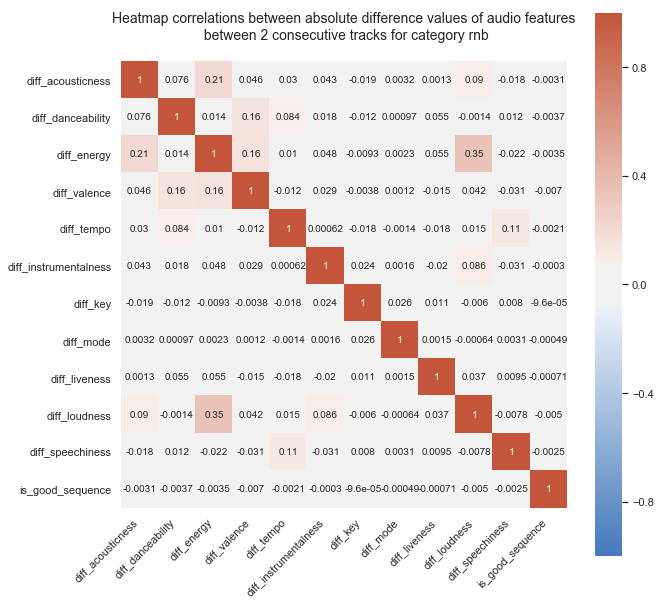

In [141]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [142]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.006752
         Iterations 12


## Summary Logit

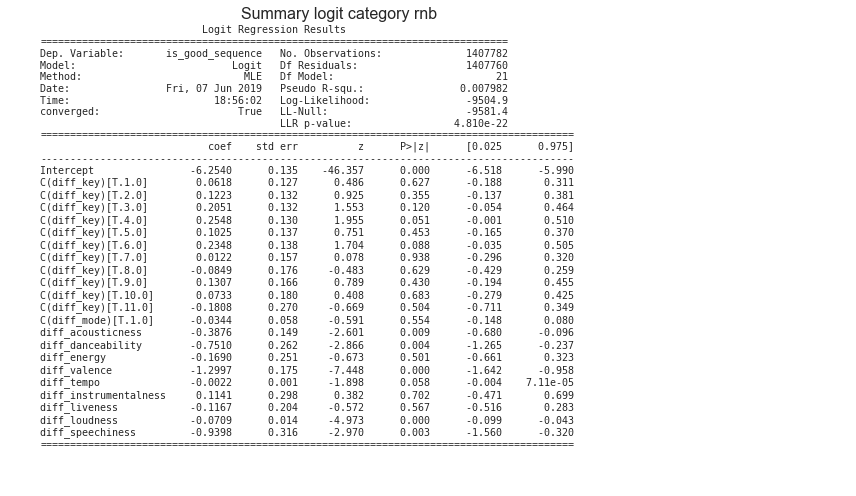

In [143]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

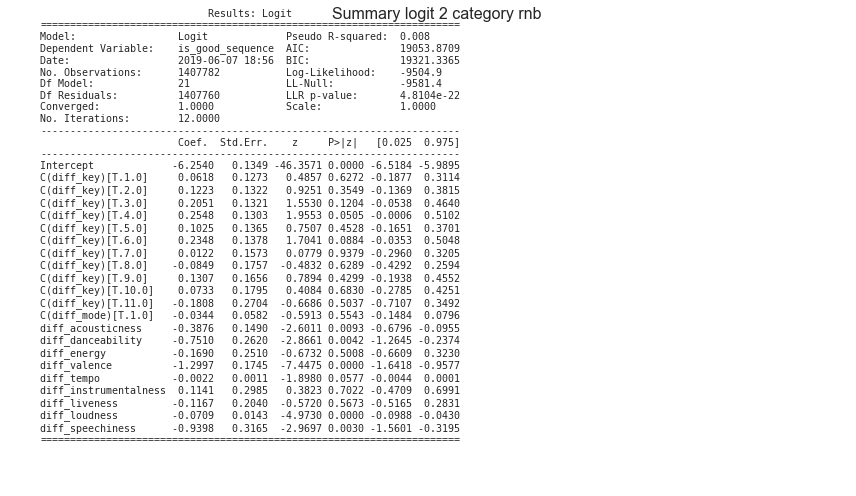

In [144]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [145]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.001923  0.000000e+00  0.001476  0.002505         True
C(key)[T.1.0]     1.063798  6.271819e-01  0.828844  1.365354        False
C(key)[T.2.0]     1.130120  3.549392e-01  0.872100  1.464478        False
C(key)[T.3.0]     1.227664  1.204349e-01  0.947661  1.590399        False
C(key)[T.4.0]     1.290212  5.054862e-02  0.999391  1.665660        False
C(key)[T.5.0]     1.107920  4.528383e-01  0.847818  1.447819        False
C(key)[T.6.0]     1.264639  8.836939e-02  0.965356  1.656706        False
C(key)[T.7.0]     1.012324  9.379142e-01  0.743819  1.377755        False
C(key)[T.8.0]     0.918611  6.289440e-01  0.651013  1.296204        False
C(key)[T.9.0]     1.139619  4.298732e-01  0.823825  1.576465        False
C(key)[T.10.0]    1.076062  6.829877e-01  0.756908  1.529788        False
C(key)[T.11.0]    0.834614  5.037334e-01  0.491287  1.417870        False
C(mode)[T.1.0]    0.966186  5.543334e-01  0.862067  1.082881        False
acousticness      0.678695  9.292951e-03  0.506802  0.908889         True
danceability      0.471910  4.156241e-03  0.282375  0.788664         True
energy            0.844533  5.008428e-01  0.516363  1.381267        False
valence           0.272605  9.511305e-14  0.193635  0.383782         True
tempo             0.997823  5.769168e-02  0.995579  1.000071        False
instrumentalness  1.120879  7.022094e-01  0.624466  2.011913        False
liveness          0.889871  5.673133e-01  0.596622  1.327256        False
loudness          0.931551  6.591142e-07  0.905879  0.957950         True
speechiness       0.390700  2.981257e-03  0.210117  0.726482         True

# Category Rock:

## Loading data

In [146]:
file = "df_diff_category_rock_2019-06-06.csv"

df = pd.read_csv(input_folder+file)

In [147]:
category = file.split('.')[-2].split('_')[-2]
category

'rock'

## Eliminating duplicates in case they exist

In [148]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16366070 entries, 0 to 16366069
Data columns (total 13 columns):
current_track-next_track    16366070 non-null object
diff_acousticness           16366070 non-null float64
diff_danceability           16366070 non-null float64
diff_energy                 16366070 non-null float64
diff_valence                16366070 non-null float64
diff_tempo                  16366070 non-null float64
diff_instrumentalness       16366070 non-null float64
diff_key                    16366070 non-null float64
diff_mode                   16366070 non-null float64
diff_liveness               16366070 non-null float64
diff_loudness               16366070 non-null float64
diff_speechiness            16366070 non-null float64
is_good_sequence            16366070 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.6+ GB


In [149]:
# check for duplicates

len(df['current_track-next_track'].unique())

16366070

In [150]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    16362025
1        4045
Name: is_good_sequence, dtype: int64

In [151]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [152]:
df['is_good_sequence'].value_counts()

0    16362025
1        4045
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [153]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       1.636607e+07       1.636607e+07  1.636607e+07  1.636607e+07   
mean        1.774119e-01       1.580496e-01  2.010367e-01  2.623050e-01   
std         2.222687e-01       1.185500e-01  1.613026e-01  1.878653e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.177000e-02       6.300000e-02  7.100000e-02  1.080000e-01   
50%         7.380000e-02       1.340000e-01  1.620000e-01  2.280000e-01   
75%         2.700370e-01       2.290000e-01  2.960000e-01  3.850000e-01   
max         9.819988e-01       8.898000e-01  9.523000e-01  9.521000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  1.636607e+07           1.636607e+07  1.636607e+07  1.636607e+07   
mean   3.386595e+01           1.561930e-01  4.048705e+00  4.357128e-01   
std    2.471085e+01           2.651195e-01  2.913384e+00  4.958499e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.373800e+01           2.564700e-04  2.000000e+00  0.000000e+00   
50%    2.919200e+01           9.130900e-03  4.000000e+00  0.000000e+00   
75%    4.947100e+01           1.829000e-01  6.000000e+00  1.000000e+00   
max    1.505630e+02           9.910000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   1.636607e+07   1.636607e+07      1.636607e+07      1.636607e+07  
mean    1.540440e-01   3.325973e+00      4.101037e-02      2.471577e-04  
std     1.563034e-01   2.781598e+00      5.348719e-02      1.571931e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     3.830000e-02   1.195000e+00      8.500000e-03      0.000000e+00  
50%     1.030000e-01   2.619000e+00      2.250000e-02      0.000000e+00  
75%     2.230000e-01   4.750000e+00      5.170000e-02      0.000000e+00  
max     9.671000e-01   2.609200e+01      4.769000e-01      1.000000e+00

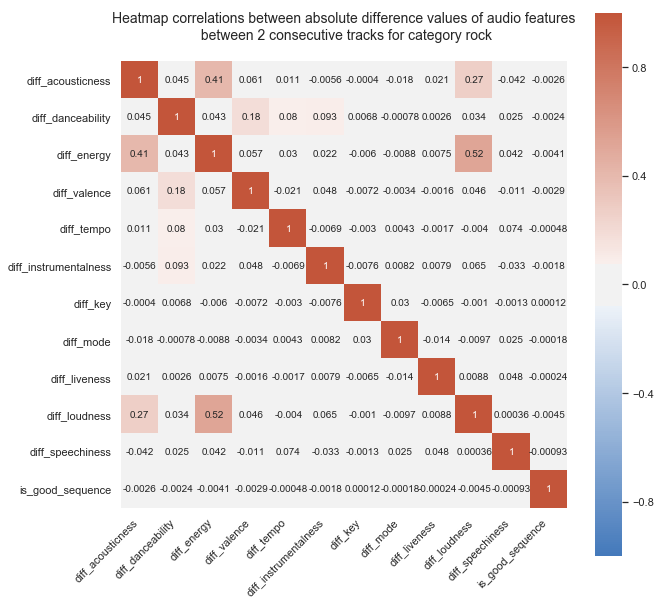

In [154]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [155]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.002278
         Iterations 13


## Summary Logit

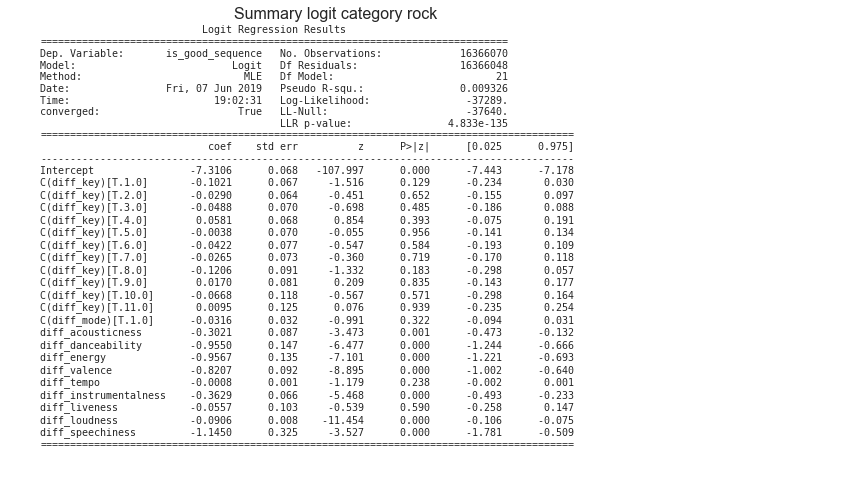

In [156]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

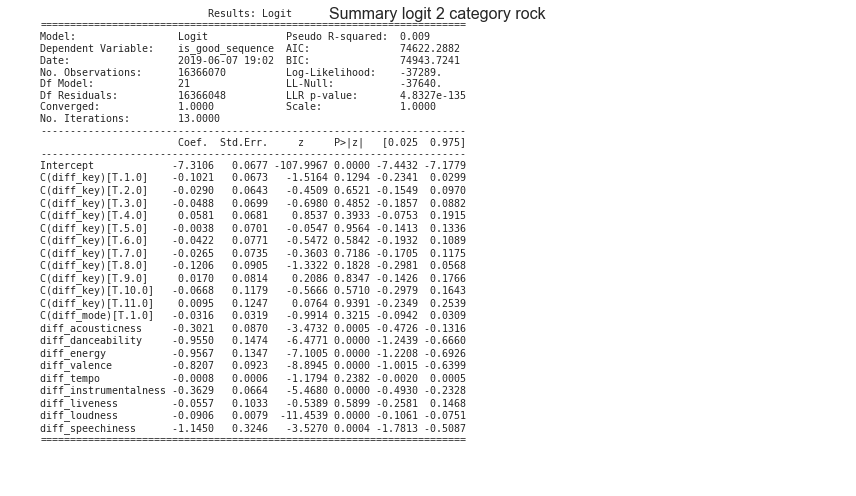

In [157]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [158]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.000668  0.000000e+00  0.000585  0.000763         True
C(key)[T.1.0]     0.902942  1.294105e-01  0.791317  1.030312        False
C(key)[T.2.0]     0.971439  6.520946e-01  0.856462  1.101852        False
C(key)[T.3.0]     0.952392  4.851536e-01  0.830491  1.092187        False
C(key)[T.4.0]     1.059816  3.932786e-01  0.927479  1.211036        False
C(key)[T.5.0]     0.996171  9.563787e-01  0.868224  1.142972        False
C(key)[T.6.0]     0.958711  5.842386e-01  0.824321  1.115010        False
C(key)[T.7.0]     0.973878  7.186497e-01  0.843268  1.124718        False
C(key)[T.8.0]     0.886369  1.827811e-01  0.742243  1.058481        False
C(key)[T.9.0]     1.017134  8.347404e-01  0.867085  1.193150        False
C(key)[T.10.0]    0.935371  5.709929e-01  0.742353  1.178575        False
C(key)[T.11.0]    1.009572  9.390988e-01  0.790687  1.289050        False
C(mode)[T.1.0]    0.968861  3.215066e-01  0.910123  1.031390        False
acousticness      0.739252  5.143203e-04  0.623377  0.876667         True
danceability      0.384831  9.348531e-11  0.288253  0.513767         True
energy            0.384162  1.242711e-12  0.295004  0.500266         True
valence           0.440123  5.867826e-19  0.367310  0.527369         True
tempo             0.999235  2.382452e-01  0.997966  1.000506        False
instrumentalness  0.695659  4.551156e-08  0.610808  0.792297         True
liveness          0.945851  5.899224e-01  0.772499  1.158104        False
loudness          0.913362  2.247235e-30  0.899308  0.927636         True
speechiness       0.318222  4.203179e-04  0.168421  0.601265         True

# Category Romance:

## Loading data

In [159]:
file = "df_diff_category_romance_2019-06-06.csv"

df = pd.read_csv(input_folder+file)

In [160]:
category = file.split('.')[-2].split('_')[-2]
category

'romance'

## Eliminating duplicates in case they exist

In [161]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336806 entries, 0 to 4336805
Data columns (total 13 columns):
current_track-next_track    4336806 non-null object
diff_acousticness           4336806 non-null float64
diff_danceability           4336806 non-null float64
diff_energy                 4336806 non-null float64
diff_valence                4336806 non-null float64
diff_tempo                  4336806 non-null float64
diff_instrumentalness       4336806 non-null float64
diff_key                    4336806 non-null float64
diff_mode                   4336806 non-null float64
diff_liveness               4336806 non-null float64
diff_loudness               4336806 non-null float64
diff_speechiness            4336806 non-null float64
is_good_sequence            4336806 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 430.1+ MB


In [162]:
# check for duplicates

len(df['current_track-next_track'].unique())

4336806

In [163]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    4334724
1       2082
Name: is_good_sequence, dtype: int64

In [164]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [165]:
df['is_good_sequence'].value_counts()

0    4334724
1       2082
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [166]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       4.336806e+06       4.336806e+06  4.336806e+06  4.336806e+06   
mean        3.815549e-01       1.740743e-01  2.588103e-01  2.386410e-01   
std         2.736271e-01       1.336867e-01  1.876853e-01  1.793564e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.380000e-01       6.800000e-02  1.060000e-01  9.400000e-02   
50%         3.360000e-01       1.450000e-01  2.240000e-01  2.010000e-01   
75%         6.030000e-01       2.500000e-01  3.780000e-01  3.470000e-01   
max         9.959804e-01       9.500000e-01  9.832900e-01  9.670000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  4.336806e+06           4.336806e+06  4.336806e+06  4.336806e+06   
mean   3.472146e+01           1.148058e-01  4.099715e+00  3.814632e-01   
std    2.622119e+01           2.603905e-01  2.943843e+00  4.857459e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.369200e+01           4.030000e-06  2.000000e+00  0.000000e+00   
50%    2.962000e+01           2.700000e-04  4.000000e+00  0.000000e+00   
75%    5.009100e+01           2.629224e-02  6.000000e+00  1.000000e+00   
max    2.085710e+02           9.770000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   4.336806e+06   4.336806e+06      4.336806e+06      4.336806e+06  
mean    9.611302e-02   5.093723e+00      4.852763e-02      4.800768e-04  
std     1.293609e-01   5.156058e+00      1.007900e-01      2.190540e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     1.840000e-02   1.624000e+00      5.600000e-03      0.000000e+00  
50%     4.580000e-02   3.560000e+00      1.470000e-02      0.000000e+00  
75%     1.180000e-01   6.583000e+00      4.100000e-02      0.000000e+00  
max     8.772000e-01   3.769600e+01      9.410000e-01      1.000000e+00

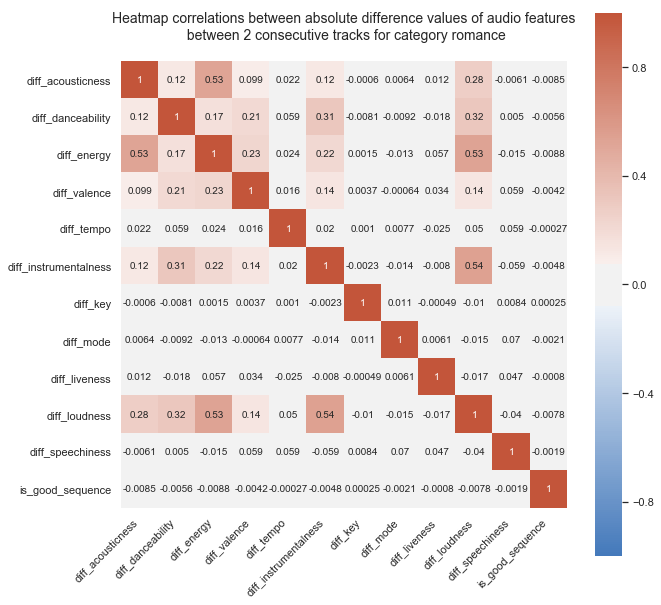

In [167]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [168]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.004064
         Iterations 13


## Summary Logit

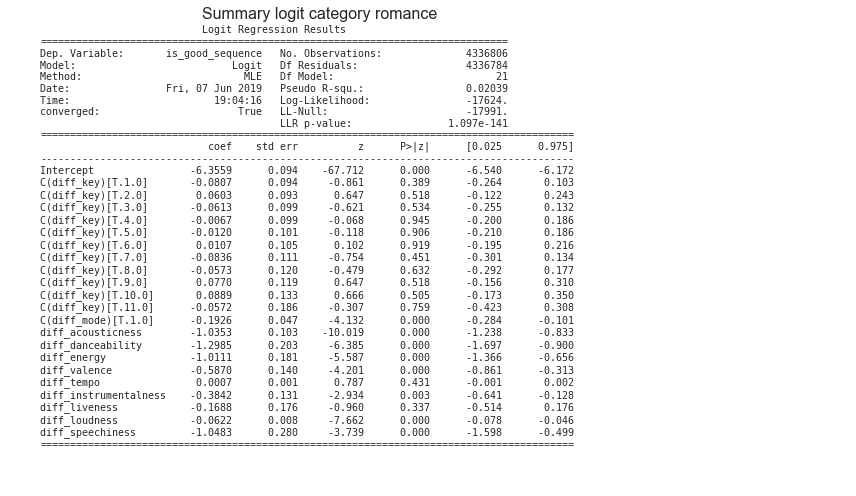

In [169]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

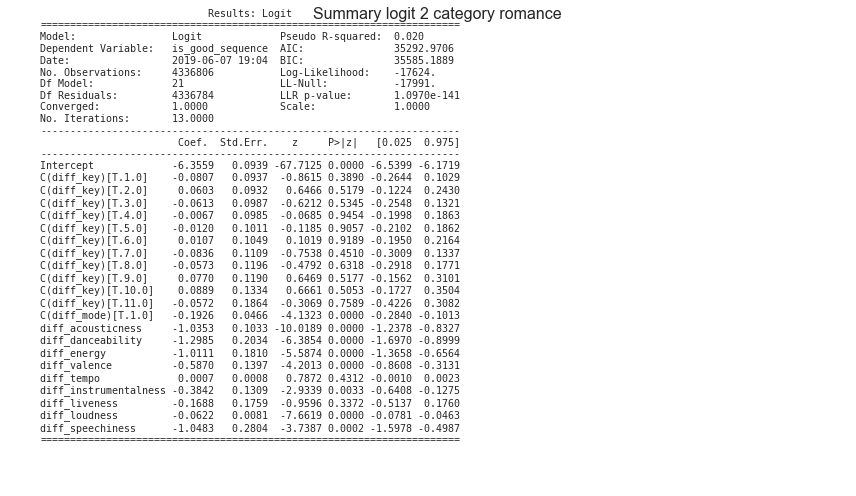

In [170]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [171]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.001737  0.000000e+00  0.001445  0.002087         True
C(key)[T.1.0]     0.922442  3.889779e-01  0.767664  1.108427        False
C(key)[T.2.0]     1.062122  5.178823e-01  0.884783  1.275006        False
C(key)[T.3.0]     0.940521  5.344578e-01  0.775078  1.141279        False
C(key)[T.4.0]     0.993274  9.453892e-01  0.818857  1.204843        False
C(key)[T.5.0]     0.988092  9.057014e-01  0.810445  1.204680        False
C(key)[T.6.0]     1.010747  9.188705e-01  0.822833  1.241576        False
C(key)[T.7.0]     0.919820  4.509531e-01  0.740166  1.143079        False
C(key)[T.8.0]     0.944283  6.317731e-01  0.746922  1.193793        False
C(key)[T.9.0]     1.080001  5.176885e-01  0.855378  1.363610        False
C(key)[T.10.0]    1.092956  5.053474e-01  0.841427  1.419674        False
C(key)[T.11.0]    0.944391  7.589173e-01  0.655336  1.360941        False
C(mode)[T.1.0]    0.824792  3.591034e-05  0.752777  0.903696         True
acousticness      0.355129  1.258563e-23  0.290021  0.434853         True
danceability      0.272947  1.709714e-10  0.183225  0.406604         True
energy            0.363819  2.304791e-08  0.255183  0.518703         True
valence           0.556014  2.653756e-05  0.422829  0.731150         True
tempo             1.000667  4.311785e-01  0.999007  1.002329        False
instrumentalness  0.681002  3.346941e-03  0.526848  0.880259         True
liveness          0.844648  3.372331e-01  0.598301  1.192427        False
loudness          0.939705  1.832087e-14  0.924874  0.954774         True
speechiness       0.350537  1.849807e-04  0.202333  0.607298         True

# Category Roots:

## Loading data

In [172]:
file = "df_diff_category_roots_2019-06-07.csv"

df = pd.read_csv(input_folder+file)

In [173]:
category = file.split('.')[-2].split('_')[-2]
category

'roots'

## Eliminating duplicates in case they exist

In [174]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21897656 entries, 0 to 21897655
Data columns (total 13 columns):
current_track-next_track    21897656 non-null object
diff_acousticness           21897656 non-null float64
diff_danceability           21897656 non-null float64
diff_energy                 21897656 non-null float64
diff_valence                21897656 non-null float64
diff_tempo                  21897656 non-null float64
diff_instrumentalness       21897656 non-null float64
diff_key                    21897656 non-null float64
diff_mode                   21897656 non-null float64
diff_liveness               21897656 non-null float64
diff_loudness               21897656 non-null float64
diff_speechiness            21897656 non-null float64
is_good_sequence            21897656 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 2.1+ GB


In [175]:
# check for duplicates

len(df['current_track-next_track'].unique())

21597852

In [176]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    21889553
1        8103
Name: is_good_sequence, dtype: int64

In [177]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [178]:
df['is_good_sequence'].value_counts()

0    21590191
1        8101
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [179]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       2.159829e+07       2.159829e+07  2.159829e+07  2.159829e+07   
mean        3.669045e-01       1.438902e-01  2.500042e-01  2.546928e-01   
std         2.726020e-01       1.080270e-01  1.815811e-01  1.896844e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.240000e-01       5.800000e-02  1.010000e-01  1.000000e-01   
50%         3.124000e-01       1.220000e-01  2.150000e-01  2.150000e-01   
75%         5.880000e-01       2.080000e-01  3.670000e-01  3.740000e-01   
max         9.949908e-01       9.410000e-01  9.928600e-01  9.990000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  2.159829e+07           2.159829e+07  2.159829e+07  2.159829e+07   
mean   3.311529e+01           1.288181e-01  4.045192e+00  3.754671e-01   
std    2.499496e+01           2.460698e-01  2.912508e+00  4.842433e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.303000e+01           2.380000e-04  2.000000e+00  0.000000e+00   
50%    2.801000e+01           5.731000e-03  4.000000e+00  0.000000e+00   
75%    4.796300e+01           1.000000e-01  6.000000e+00  1.000000e+00   
max    2.095860e+02           9.870000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   2.159829e+07   2.159829e+07      2.159829e+07      2.159829e+07  
mean    1.142541e-01   4.147218e+00      2.077680e-02      3.750760e-04  
std     1.652674e-01   3.305099e+00      4.336560e-02      1.936325e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     1.740000e-02   1.595000e+00      3.500000e-03      0.000000e+00  
50%     4.600000e-02   3.406000e+00      8.400000e-03      0.000000e+00  
75%     1.430000e-01   5.916000e+00      1.980000e-02      0.000000e+00  
max     9.600000e-01   3.623800e+01      6.757000e-01      1.000000e+00

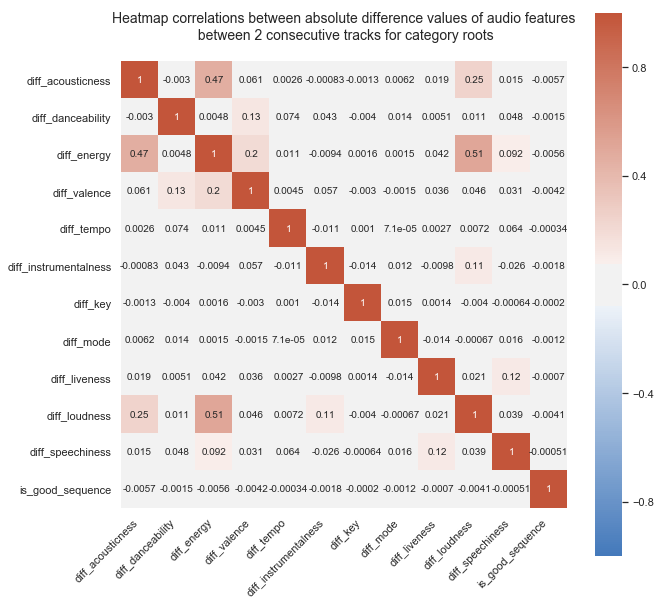

In [180]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [181]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.003299
         Iterations 12


## Summary Logit

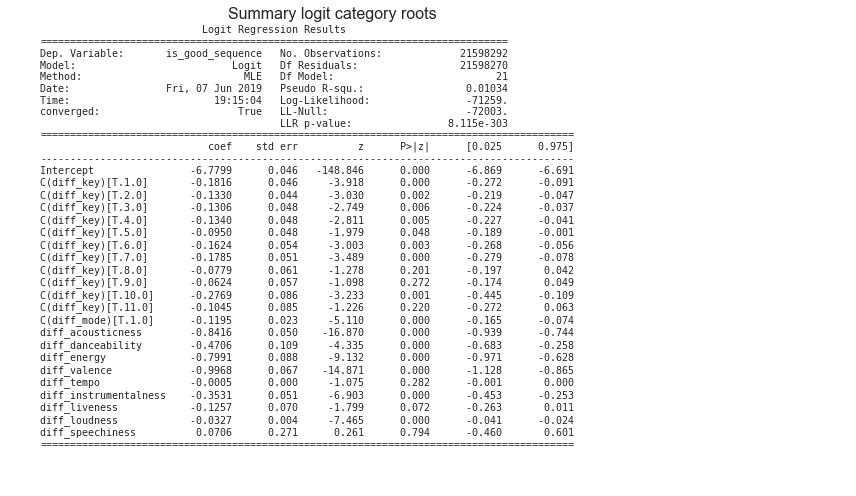

In [182]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

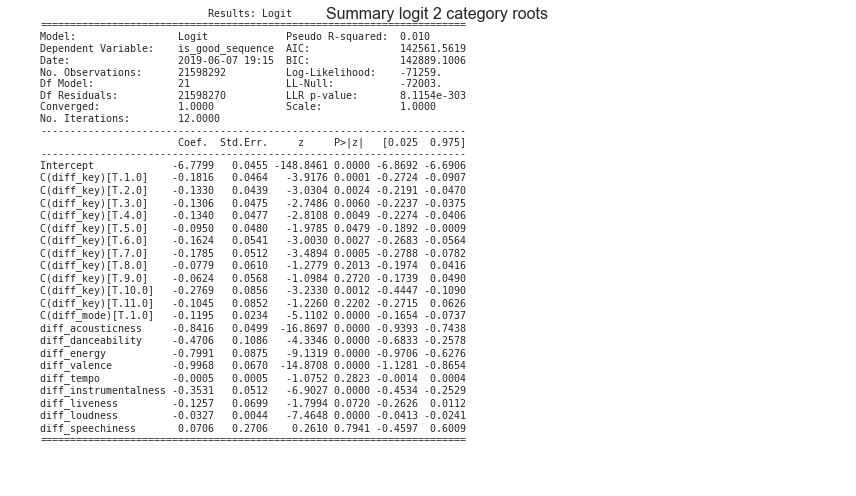

In [183]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [184]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.001136  0.000000e+00  0.001039  0.001243         True
C(key)[T.1.0]     0.833948  8.943152e-05  0.761526  0.913256         True
C(key)[T.2.0]     0.875427  2.442382e-03  0.803247  0.954092         True
C(key)[T.3.0]     0.877559  5.985201e-03  0.799517  0.963218         True
C(key)[T.4.0]     0.874602  4.942041e-03  0.796589  0.960254         True
C(key)[T.5.0]     0.909336  4.786737e-02  0.827630  0.999108         True
C(key)[T.6.0]     0.850134  2.673101e-03  0.764656  0.945166         True
C(key)[T.7.0]     0.836525  4.841014e-04  0.756721  0.924744         True
C(key)[T.8.0]     0.925031  2.012764e-01  0.820823  1.042468        False
C(key)[T.9.0]     0.939466  2.720173e-01  0.840410  1.050196        False
C(key)[T.10.0]    0.758144  1.225098e-03  0.640991  0.896708         True
C(key)[T.11.0]    0.900784  2.202017e-01  0.762209  1.064553        False
C(mode)[T.1.0]    0.887340  3.218900e-07  0.847579  0.928966         True
acousticness      0.431041  7.517632e-64  0.390892  0.475315         True
danceability      0.624644  1.460082e-05  0.504923  0.772752         True
energy            0.449728  6.727653e-20  0.378846  0.533871         True
valence           0.369075  5.097760e-50  0.323639  0.420890         True
tempo             0.999515  2.822675e-01  0.998633  1.000399        False
instrumentalness  0.702489  5.102235e-12  0.635469  0.776578         True
liveness          0.881867  7.195854e-02  0.769013  1.011282        False
loudness          0.967810  8.345476e-14  0.959532  0.976160         True
speechiness       1.073169  7.940852e-01  0.631502  1.823735        False

# Category Sessions:

## Loading data

In [185]:
file = "df_diff_category_sessions_2019-06-06.csv"

df = pd.read_csv(input_folder+file)

In [186]:
category = file.split('.')[-2].split('_')[-2]
category

'sessions'

## Eliminating duplicates in case they exist

In [187]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282492 entries, 0 to 282491
Data columns (total 13 columns):
current_track-next_track    282492 non-null object
diff_acousticness           282492 non-null float64
diff_danceability           282492 non-null float64
diff_energy                 282492 non-null float64
diff_valence                282492 non-null float64
diff_tempo                  282492 non-null float64
diff_instrumentalness       282492 non-null float64
diff_key                    282492 non-null float64
diff_mode                   282492 non-null float64
diff_liveness               282492 non-null float64
diff_loudness               282492 non-null float64
diff_speechiness            282492 non-null float64
is_good_sequence            282492 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 28.0+ MB


In [188]:
# check for duplicates

len(df['current_track-next_track'].unique())

282492

In [189]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    281961
1       531
Name: is_good_sequence, dtype: int64

In [190]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [191]:
df['is_good_sequence'].value_counts()

0    281961
1       531
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [192]:
df.describe()

diff_acousticness  diff_danceability    diff_energy   diff_valence  \
count      282492.000000      282492.000000  282492.000000  282492.000000   
mean            0.379706           0.150382       0.240046       0.237309   
std             0.273658           0.111849       0.174489       0.172270   
min             0.000000           0.000000       0.000000       0.000000   
25%             0.131000           0.061000       0.098000       0.096000   
50%             0.338000           0.129000       0.208000       0.205000   
75%             0.605700           0.218000       0.349000       0.348000   
max             0.982985           0.774000       0.925300       0.898600   

          diff_tempo  diff_instrumentalness       diff_key      diff_mode  \
count  282492.000000          282492.000000  282492.000000  282492.000000   
mean       32.491742               0.083257       4.048193       0.449790   
std        24.417123               0.215229       2.898906       0.497473   
min         0.000000               0.000000       0.000000       0.000000   
25%        12.845000               0.000006       2.000000       0.000000   
50%        27.669000               0.000410       4.000000       0.000000   
75%        47.097000               0.015670       6.000000       1.000000   
max       145.077000               0.963000      11.000000       1.000000   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count  282492.000000  282492.000000     282492.000000     282492.000000  
mean        0.110535       3.144236          0.052429          0.001880  
std         0.155493       2.480612          0.083304          0.043315  
min         0.000000       0.000000          0.000000          0.000000  
25%         0.017000       1.222000          0.007100          0.000000  
50%         0.045300       2.593000          0.019000          0.000000  
75%         0.151400       4.472000          0.055600          0.000000  
max         0.919700      18.527000          0.495300          1.000000

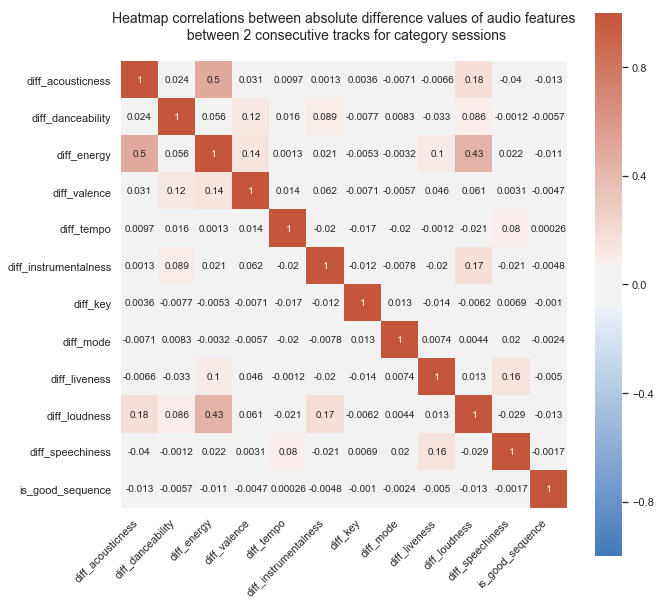

In [193]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [194]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.013464
         Iterations 11


## Summary Logit

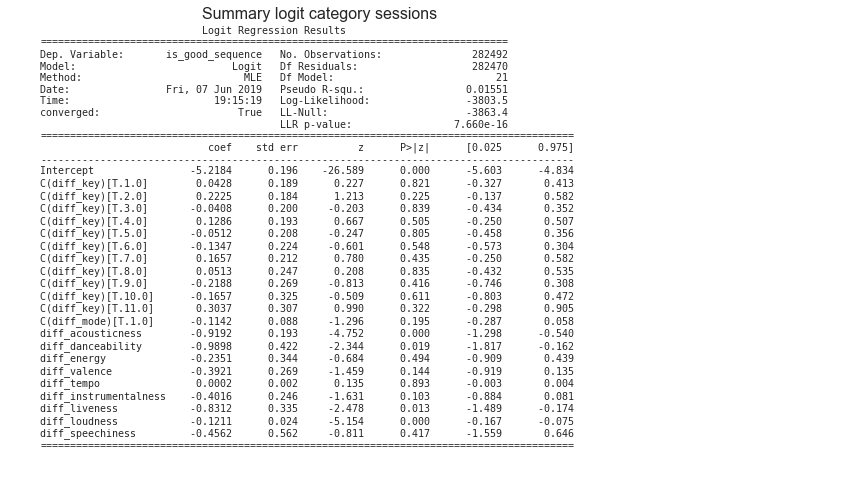

In [195]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category+'\n', {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

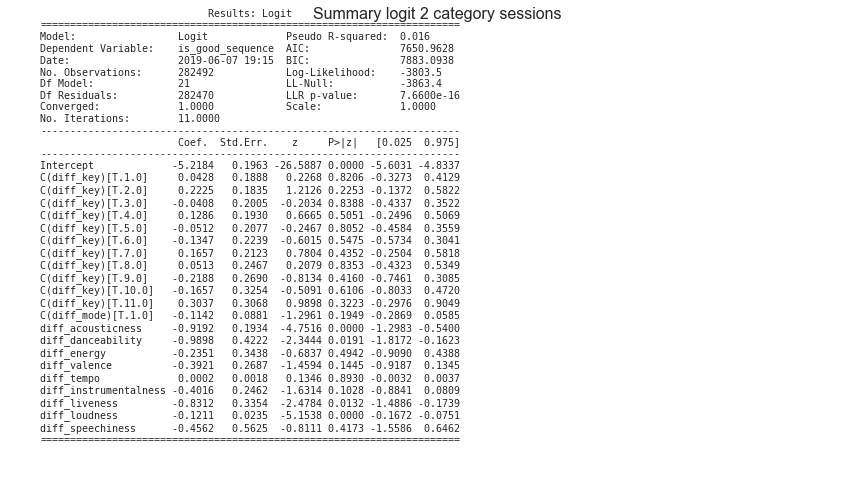

In [196]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [197]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR        p-value      2.5%     97.5%  significant
Intercept         0.005416  9.164410e-156  0.003686  0.007957         True
C(key)[T.1.0]     1.043756   8.205861e-01  0.720879  1.511248        False
C(key)[T.2.0]     1.249250   2.252816e-01  0.871831  1.790055        False
C(key)[T.3.0]     0.960033   8.387872e-01  0.648089  1.422126        False
C(key)[T.4.0]     1.137274   5.050875e-01  0.779085  1.660144        False
C(key)[T.5.0]     0.950044   8.051574e-01  0.632280  1.427508        False
C(key)[T.6.0]     0.874019   5.475378e-01  0.563578  1.355462        False
C(key)[T.7.0]     1.180192   4.351750e-01  0.778461  1.789240        False
C(key)[T.8.0]     1.052645   8.352721e-01  0.649030  1.707258        False
C(key)[T.9.0]     0.803457   4.159924e-01  0.474197  1.361339        False
C(key)[T.10.0]    0.847340   6.106495e-01  0.447832  1.603247        False
C(key)[T.11.0]    1.354807   3.222566e-01  0.742587  2.471768        False
C(mode)[T.1.0]    0.892092   1.949275e-01  0.750621  1.060225        False
acousticness      0.398850   2.018538e-06  0.272990  0.582735         True
danceability      0.371661   1.905620e-02  0.162475  0.850174         True
energy            0.790514   4.941723e-01  0.402941  1.550877        False
valence           0.675638   1.444667e-01  0.399038  1.143967        False
tempo             1.000239   8.929668e-01  0.996758  1.003733        False
instrumentalness  0.669250   1.028158e-01  0.413090  1.084257        False
liveness          0.435505   1.319580e-02  0.225687  0.840387         True
loudness          0.885923   2.552639e-07  0.846040  0.927686         True
speechiness       0.633667   4.172874e-01  0.210424  1.908216        False

# Category Sleep:

## Loading data

In [198]:
file = "df_diff_category_sleep_2019-06-06.csv"

df = pd.read_csv(input_folder+file)

In [199]:
category = file.split('.')[-2].split('_')[-2]
category

'sleep'

## Eliminating duplicates in case they exist

In [200]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2895102 entries, 0 to 2895101
Data columns (total 13 columns):
current_track-next_track    2895102 non-null object
diff_acousticness           2895102 non-null float64
diff_danceability           2895102 non-null float64
diff_energy                 2895102 non-null float64
diff_valence                2895102 non-null float64
diff_tempo                  2895102 non-null float64
diff_instrumentalness       2895102 non-null float64
diff_key                    2895102 non-null float64
diff_mode                   2895102 non-null float64
diff_liveness               2895102 non-null float64
diff_loudness               2895102 non-null float64
diff_speechiness            2895102 non-null float64
is_good_sequence            2895102 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 287.1+ MB


In [201]:
# check for duplicates

len(df['current_track-next_track'].unique())

2895102

In [202]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    2893401
1       1701
Name: is_good_sequence, dtype: int64

In [203]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [204]:
df['is_good_sequence'].value_counts()

0    2893401
1       1701
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [205]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       2.895102e+06       2.895102e+06  2.895102e+06  2.895102e+06   
mean        3.680736e-01       2.218177e-01  2.970841e-01  1.464774e-01   
std         3.500131e-01       1.649826e-01  2.957458e-01  1.602835e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         4.400000e-02       8.600000e-02  5.730000e-02  3.280000e-02   
50%         2.190000e-01       1.880000e-01  1.774100e-01  8.620000e-02   
75%         7.360000e-01       3.300000e-01  4.723000e-01  2.140000e-01   
max         9.960000e-01       9.470000e-01  1.000000e+00  9.600000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  2.895102e+06           2.895102e+06  2.895102e+06  2.895102e+06   
mean   4.577160e+01           2.321570e-01  4.050046e+00  4.665535e-01   
std    3.743284e+01           2.998252e-01  2.942883e+00  4.988802e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.500700e+01           3.300000e-02  2.000000e+00  0.000000e+00   
50%    3.761600e+01           8.200000e-02  4.000000e+00  0.000000e+00   
75%    6.807600e+01           3.080000e-01  6.000000e+00  1.000000e+00   
max    2.140410e+02           1.000000e+00  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   2.895102e+06   2.895102e+06      2.895102e+06      2.895102e+06  
mean    2.149290e-01   1.052781e+01      5.234239e-02      5.875441e-04  
std     2.664641e-01   8.889844e+00      1.079805e-01      2.423219e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     1.890000e-02   3.790000e+00      7.400000e-03      0.000000e+00  
50%     7.080000e-02   8.163000e+00      1.970000e-02      0.000000e+00  
75%     3.190000e-01   1.469700e+01      4.440000e-02      0.000000e+00  
max     9.830000e-01   5.468700e+01      8.680000e-01      1.000000e+00

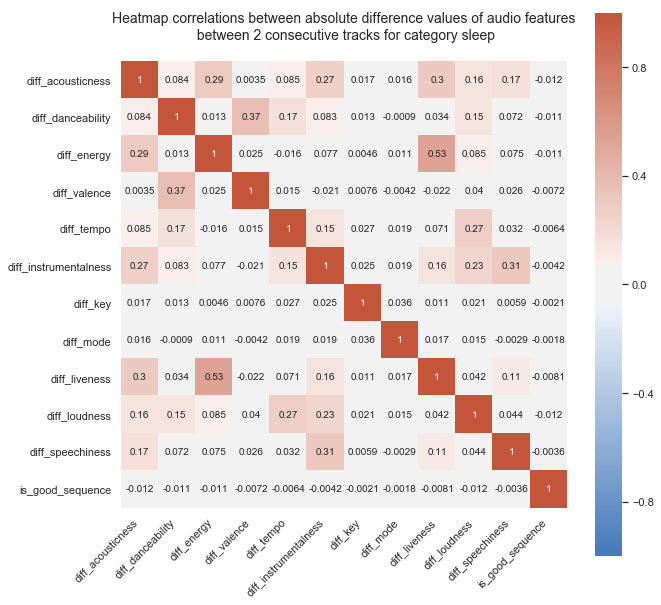

In [206]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [207]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.004706
         Iterations 13


## Summary Logit

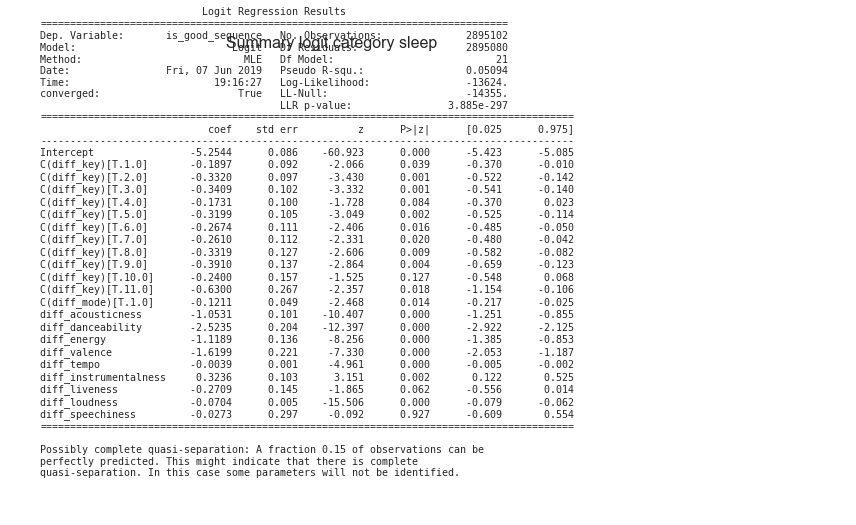

In [208]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

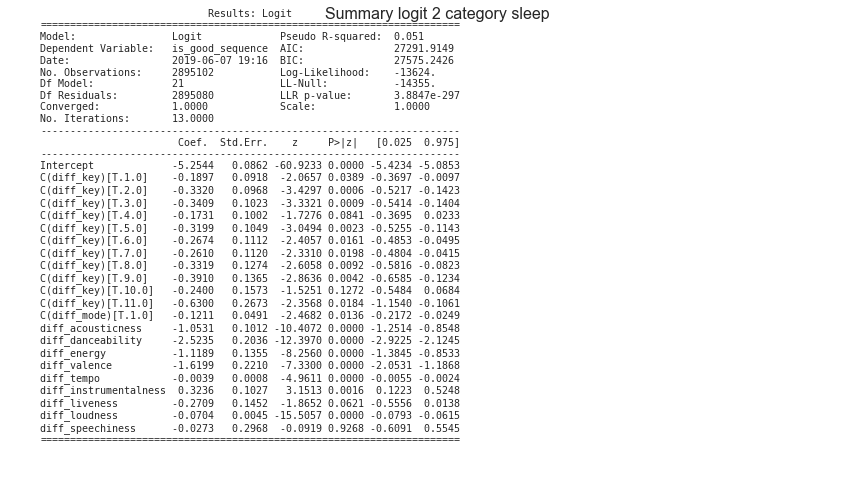

In [209]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [210]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.005225  0.000000e+00  0.004412  0.006187         True
C(key)[T.1.0]     0.827191  3.885794e-02  0.690922  0.990337         True
C(key)[T.2.0]     0.717516  6.043496e-04  0.593531  0.867402         True
C(key)[T.3.0]     0.711148  8.618384e-04  0.581947  0.869035         True
C(key)[T.4.0]     0.841038  8.406274e-02  0.691063  1.023560        False
C(key)[T.5.0]     0.726241  2.293211e-03  0.591277  0.892011         True
C(key)[T.6.0]     0.765364  1.614161e-02  0.615536  0.951662         True
C(key)[T.7.0]     0.770309  1.975141e-02  0.618545  0.959309         True
C(key)[T.8.0]     0.717536  9.166514e-03  0.559004  0.921027         True
C(key)[T.9.0]     0.676412  4.188509e-03  0.517608  0.883937         True
C(key)[T.10.0]    0.786649  1.272364e-01  0.577889  1.070823        False
C(key)[T.11.0]    0.532578  1.843187e-02  0.315385  0.899345         True
C(mode)[T.1.0]    0.885953  1.357873e-02  0.804731  0.975373         True
acousticness      0.348860  2.297901e-25  0.286101  0.425385         True
danceability      0.080179  2.711643e-35  0.053802  0.119489         True
energy            0.326635  1.506968e-16  0.250438  0.426014         True
valence           0.197917  2.302228e-13  0.128342  0.305209         True
tempo             0.996093  7.008618e-07  0.994554  0.997635         True
instrumentalness  1.382039  1.625305e-03  1.130118  1.690116         True
liveness          0.762681  6.214861e-02  0.573734  1.013854        False
loudness          0.932017  3.176487e-54  0.923760  0.940349         True
speechiness       0.973092  9.267838e-01  0.543866  1.741069        False

# Category Soul:

## Loading data

In [211]:
file = "df_diff_category_soul_2019-06-06.csv"

df = pd.read_csv(input_folder+file)

In [212]:
category = file.split('.')[-2].split('_')[-2]
category

'soul'

## Eliminating duplicates in case they exist

In [213]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191880 entries, 0 to 2191879
Data columns (total 13 columns):
current_track-next_track    2191880 non-null object
diff_acousticness           2191880 non-null float64
diff_danceability           2191880 non-null float64
diff_energy                 2191880 non-null float64
diff_valence                2191880 non-null float64
diff_tempo                  2191880 non-null float64
diff_instrumentalness       2191880 non-null float64
diff_key                    2191880 non-null float64
diff_mode                   2191880 non-null float64
diff_liveness               2191880 non-null float64
diff_loudness               2191880 non-null float64
diff_speechiness            2191880 non-null float64
is_good_sequence            2191880 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 217.4+ MB


In [214]:
# check for duplicates

len(df['current_track-next_track'].unique())

2191880

In [215]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    2190400
1       1480
Name: is_good_sequence, dtype: int64

In [216]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [217]:
df['is_good_sequence'].value_counts()

0    2190400
1       1480
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [218]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       2.191880e+06       2.191880e+06  2.191880e+06  2.191880e+06   
mean        2.928196e-01       1.674420e-01  2.155203e-01  2.757531e-01   
std         2.290911e-01       1.250231e-01  1.590985e-01  1.987030e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.010000e-01       6.700000e-02  8.700000e-02  1.100000e-01   
50%         2.387600e-01       1.420000e-01  1.840000e-01  2.390000e-01   
75%         4.430000e-01       2.430000e-01  3.130000e-01  4.100000e-01   
max         9.949337e-01       7.840000e-01  9.844000e-01  9.482000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  2.191880e+06           2.191880e+06  2.191880e+06  2.191880e+06   
mean   3.100246e+01           8.767708e-02  4.124976e+00  4.976276e-01   
std    2.564144e+01           2.008018e-01  2.971927e+00  4.999945e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.106800e+01           3.498750e-05  2.000000e+00  0.000000e+00   
50%    2.415800e+01           1.260000e-03  4.000000e+00  0.000000e+00   
75%    4.422100e+01           3.460000e-02  6.000000e+00  1.000000e+00   
max    1.531600e+02           9.490000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   2.191880e+06   2.191880e+06      2.191880e+06      2.191880e+06  
mean    1.437103e-01   3.657336e+00      7.524696e-02      6.752194e-04  
std     1.704117e-01   2.928732e+00      9.043300e-02      2.597622e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     2.950000e-02   1.409000e+00      1.330000e-02      0.000000e+00  
50%     7.460000e-02   3.002000e+00      3.810000e-02      0.000000e+00  
75%     1.990000e-01   5.200000e+00      1.024000e-01      0.000000e+00  
max     9.636000e-01   2.542700e+01      8.619000e-01      1.000000e+00

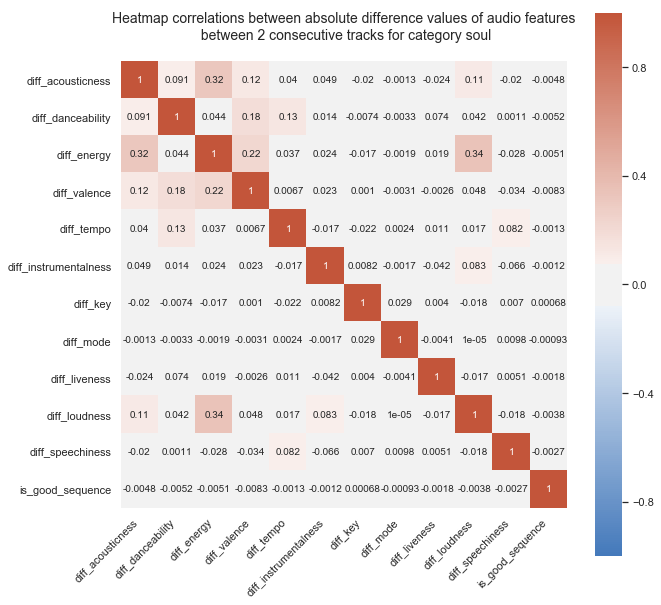

In [219]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [220]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.005535
         Iterations 12


## Summary Logit

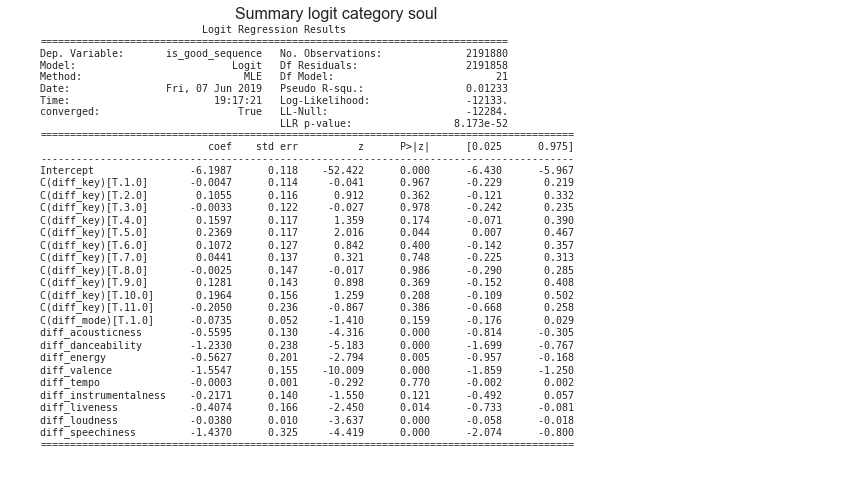

In [221]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

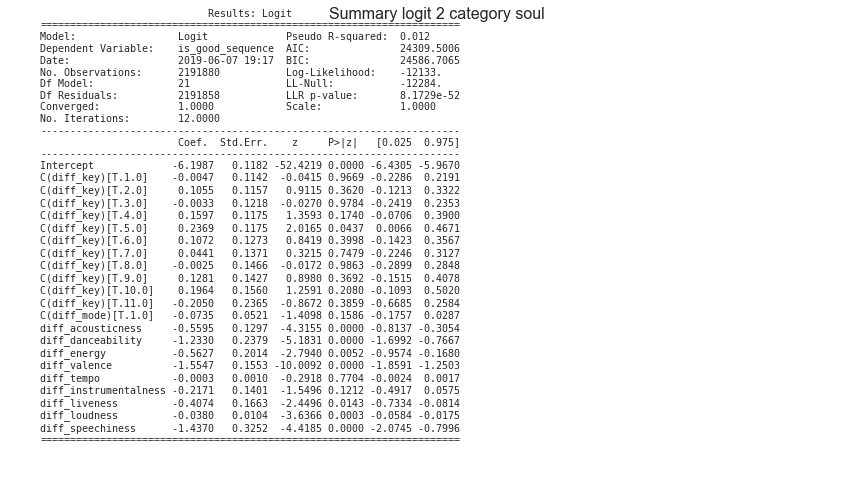

In [222]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [223]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.002032  0.000000e+00  0.001612  0.002562         True
C(key)[T.1.0]     0.995275  9.669210e-01  0.795647  1.244989        False
C(key)[T.2.0]     1.111219  3.620128e-01  0.885773  1.394046        False
C(key)[T.3.0]     0.996712  9.784206e-01  0.785111  1.265344        False
C(key)[T.4.0]     1.173177  1.740415e-01  0.931861  1.476985        False
C(key)[T.5.0]     1.267260  4.374933e-02  1.006661  1.595322         True
C(key)[T.6.0]     1.113147  3.998295e-01  0.867322  1.428647        False
C(key)[T.7.0]     1.045044  7.478639e-01  0.798858  1.367096        False
C(key)[T.8.0]     0.997484  9.862897e-01  0.748365  1.329530        False
C(key)[T.9.0]     1.136703  3.692043e-01  0.859385  1.503510        False
C(key)[T.10.0]    1.216962  2.079922e-01  0.896462  1.652046        False
C(key)[T.11.0]    0.814610  3.858590e-01  0.512478  1.294864        False
C(mode)[T.1.0]    0.929122  1.586113e-01  0.838852  1.029107        False
acousticness      0.571474  1.592172e-05  0.443234  0.736818         True
danceability      0.291418  2.182651e-07  0.182821  0.464524         True
energy            0.569685  5.206740e-03  0.383895  0.845390         True
valence           0.211254  1.388590e-23  0.155808  0.286430         True
tempo             0.999695  7.704412e-01  0.997645  1.001748        False
instrumentalness  0.804841  1.212370e-01  0.611576  1.059180        False
liveness          0.665373  1.429990e-02  0.480285  0.921788         True
loudness          0.962738  2.762753e-04  0.943235  0.982645         True
speechiness       0.237633  9.938195e-06  0.125624  0.449513         True

# Category Toplists:

## Loading data

In [224]:
file = "df_diff_category_toplists_2019-06-06.csv"

df = pd.read_csv(input_folder+file)

In [225]:
category = file.split('.')[-2].split('_')[-2]
category

'toplists'

## Eliminating duplicates in case they exist

In [226]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551306 entries, 0 to 551305
Data columns (total 13 columns):
current_track-next_track    551306 non-null object
diff_acousticness           551306 non-null float64
diff_danceability           551306 non-null float64
diff_energy                 551306 non-null float64
diff_valence                551306 non-null float64
diff_tempo                  551306 non-null float64
diff_instrumentalness       551306 non-null float64
diff_key                    551306 non-null float64
diff_mode                   551306 non-null float64
diff_liveness               551306 non-null float64
diff_loudness               551306 non-null float64
diff_speechiness            551306 non-null float64
is_good_sequence            551306 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 54.7+ MB


In [227]:
# check for duplicates

len(df['current_track-next_track'].unique())

551306

In [228]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    550564
1       742
Name: is_good_sequence, dtype: int64

In [229]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [230]:
df['is_good_sequence'].value_counts()

0    550564
1       742
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [231]:
df.describe()

diff_acousticness  diff_danceability    diff_energy   diff_valence  \
count      551306.000000      551306.000000  551306.000000  551306.000000   
mean            0.241992           0.167051       0.204973       0.247445   
std             0.220213           0.126173       0.152603       0.178507   
min             0.000000           0.000000       0.000000       0.000000   
25%             0.064510           0.067000       0.082000       0.102000   
50%             0.174830           0.141000       0.175000       0.215000   
75%             0.362860           0.241000       0.298000       0.361000   
max             0.978985           0.767000       0.949800       0.931500   

          diff_tempo  diff_instrumentalness       diff_key      diff_mode  \
count  551306.000000          551306.000000  551306.000000  551306.000000   
mean       31.600542               0.107677       4.203147       0.483151   
std        23.840267               0.232056       3.029380       0.499716   
min         0.000000               0.000000       0.000000       0.000000   
25%        12.105000               0.000003       2.000000       0.000000   
50%        27.130000               0.000300       4.000000       0.000000   
75%        45.945000               0.045100       6.000000       1.000000   
max       166.570000               0.951000      11.000000       1.000000   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count  551306.000000  551306.000000     551306.000000     551306.000000  
mean        0.126012       2.928034          0.104737          0.001346  
std         0.136556       2.730013          0.113278          0.036662  
min         0.000000       0.000000          0.000000          0.000000  
25%         0.029000       1.062000          0.018300          0.000000  
50%         0.075000       2.270000          0.058600          0.000000  
75%         0.185000       4.006000          0.160000          0.000000  
max         0.933900      32.651000          0.564300          1.000000

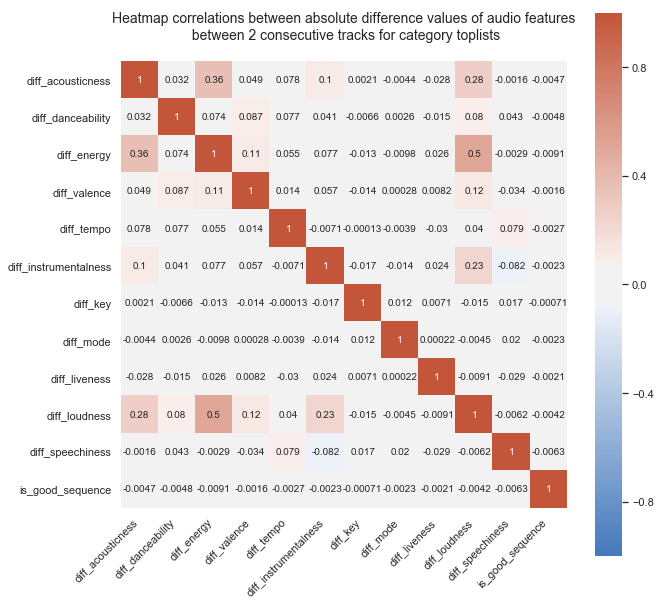

In [232]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [233]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.010151
         Iterations 11


## Summary Logit

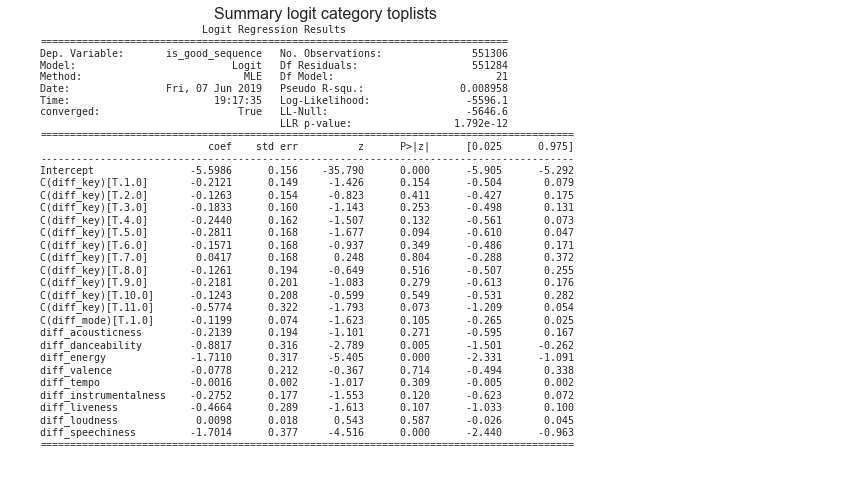

In [234]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

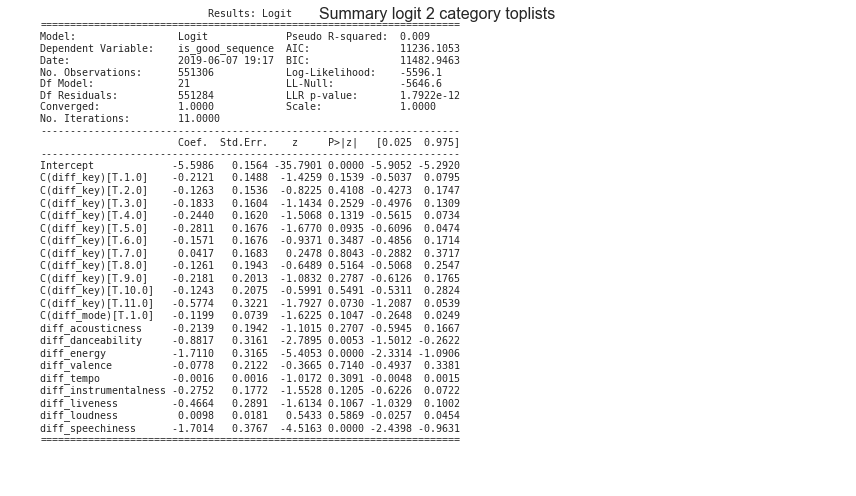

In [235]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [236]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR        p-value      2.5%     97.5%  significant
Intercept         0.003703  1.573058e-280  0.002725  0.005031         True
C(key)[T.1.0]     0.808863   1.539001e-01  0.604287  1.082695        False
C(key)[T.2.0]     0.881343   4.107714e-01  0.652282  1.190844        False
C(key)[T.3.0]     0.832479   2.528687e-01  0.607969  1.139895        False
C(key)[T.4.0]     0.783449   1.318668e-01  0.570353  1.076162        False
C(key)[T.5.0]     0.754955   9.354671e-02  0.543552  1.048577        False
C(key)[T.6.0]     0.854648   3.486956e-01  0.615351  1.187004        False
C(key)[T.7.0]     1.042604   8.042537e-01  0.749604  1.450131        False
C(key)[T.8.0]     0.881568   5.164199e-01  0.602418  1.290071        False
C(key)[T.9.0]     0.804082   2.787124e-01  0.541940  1.193024        False
C(key)[T.10.0]    0.883073   5.490875e-01  0.587940  1.326358        False
C(key)[T.11.0]    0.561354   7.301950e-02  0.298592  1.055348        False
C(mode)[T.1.0]    0.886979   1.046949e-01  0.767351  1.025258        False
acousticness      0.807427   2.706812e-01  0.551830  1.181410        False
danceability      0.414076   5.279605e-03  0.222858  0.769364         True
energy            0.180686   6.471068e-08  0.097159  0.336020         True
valence           0.925167   7.139557e-01  0.610375  1.402309        False
tempo             0.998362   3.090722e-01  0.995213  1.001521        False
instrumentalness  0.759410   1.204633e-01  0.536555  1.074825        False
liveness          0.627275   1.066606e-01  0.355965  1.105373        False
loudness          1.009895   5.869486e-01  0.974651  1.046413        False
speechiness       0.182421   6.291575e-06  0.087177  0.381721         True

# Category Travel:

## Loading data

In [237]:
file = "df_diff_category_travel_2019-06-06.csv"

df = pd.read_csv(input_folder+file)

In [238]:
category = file.split('.')[-2].split('_')[-2]
category

'travel'

## Eliminating duplicates in case they exist

In [239]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348556 entries, 0 to 2348555
Data columns (total 13 columns):
current_track-next_track    2348556 non-null object
diff_acousticness           2348556 non-null float64
diff_danceability           2348556 non-null float64
diff_energy                 2348556 non-null float64
diff_valence                2348556 non-null float64
diff_tempo                  2348556 non-null float64
diff_instrumentalness       2348556 non-null float64
diff_key                    2348556 non-null float64
diff_mode                   2348556 non-null float64
diff_liveness               2348556 non-null float64
diff_loudness               2348556 non-null float64
diff_speechiness            2348556 non-null float64
is_good_sequence            2348556 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 232.9+ MB


In [240]:
# check for duplicates

len(df['current_track-next_track'].unique())

2348556

In [241]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    2347024
1       1532
Name: is_good_sequence, dtype: int64

In [242]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [243]:
df['is_good_sequence'].value_counts()

0    2347024
1       1532
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [244]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       2.348556e+06       2.348556e+06  2.348556e+06  2.348556e+06   
mean        3.011957e-01       1.536366e-01  2.250112e-01  2.628201e-01   
std         2.532851e-01       1.145547e-01  1.664647e-01  1.878087e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         8.050000e-02       6.200000e-02  9.000000e-02  1.080000e-01   
50%         2.320000e-01       1.310000e-01  1.920000e-01  2.290000e-01   
75%         4.861000e-01       2.220000e-01  3.290000e-01  3.860000e-01   
max         9.949974e-01       7.840000e-01  9.570000e-01  9.500000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  2.348556e+06           2.348556e+06  2.348556e+06  2.348556e+06   
mean   3.120441e+01           1.111355e-01  4.072545e+00  4.015931e-01   
std    2.363192e+01           2.373651e-01  2.929109e+00  4.902206e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.230100e+01           4.740000e-05  2.000000e+00  0.000000e+00   
50%    2.625600e+01           1.657000e-03  4.000000e+00  0.000000e+00   
75%    4.503600e+01           6.728000e-02  6.000000e+00  1.000000e+00   
max    1.651220e+02           9.560000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   2.348556e+06   2.348556e+06      2.348556e+06      2.348556e+06  
mean    1.283653e-01   3.524483e+00      4.481729e-02      6.523157e-04  
std     1.447285e-01   2.907275e+00      6.947552e-02      2.553215e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     3.000000e-02   1.316000e+00      6.700000e-03      0.000000e+00  
50%     7.470000e-02   2.826000e+00      1.830000e-02      0.000000e+00  
75%     1.810000e-01   4.978000e+00      4.980000e-02      0.000000e+00  
max     9.533000e-01   2.511700e+01      4.868000e-01      1.000000e+00

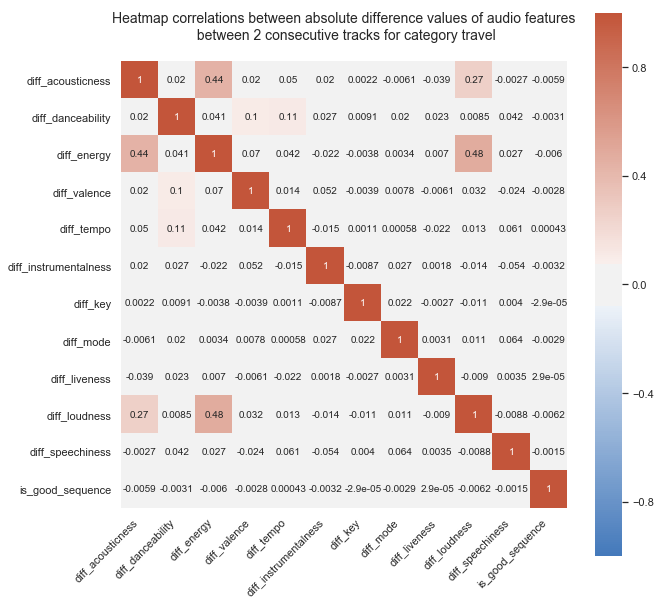

In [245]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [246]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.005382
         Iterations 12


## Summary Logit

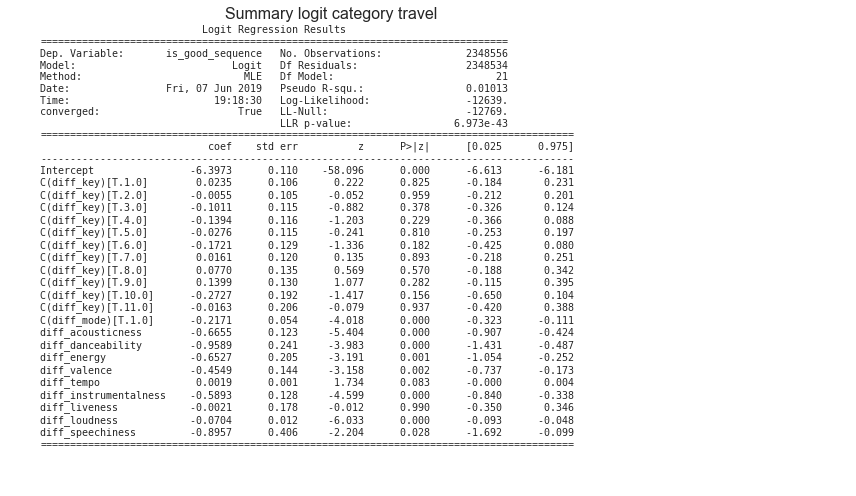

In [247]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

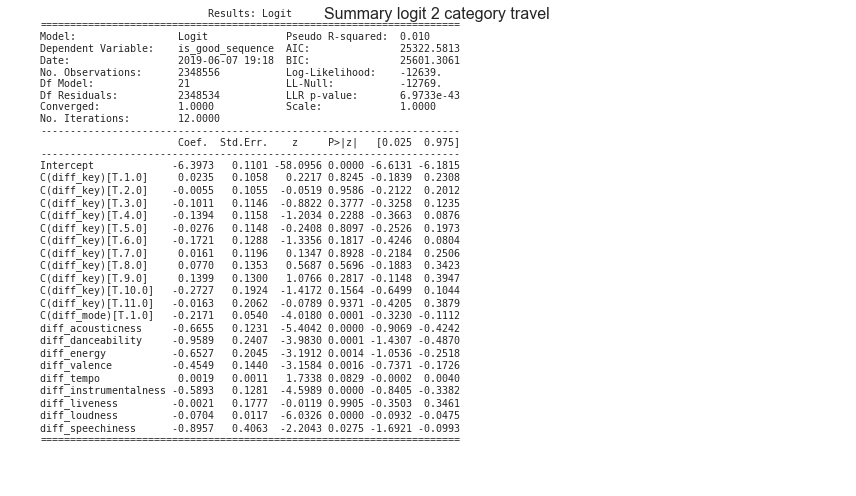

In [248]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [249]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.001666  0.000000e+00  0.001343  0.002067         True
C(key)[T.1.0]     1.023738  8.245186e-01  0.832009  1.259650        False
C(key)[T.2.0]     0.994545  9.586353e-01  0.808825  1.222910        False
C(key)[T.3.0]     0.903812  3.776563e-01  0.721938  1.131504        False
C(key)[T.4.0]     0.869923  2.288319e-01  0.693285  1.091566        False
C(key)[T.5.0]     0.972737  8.096832e-01  0.776783  1.218123        False
C(key)[T.6.0]     0.841908  1.816769e-01  0.654022  1.083768        False
C(key)[T.7.0]     1.016249  8.928245e-01  0.803835  1.284793        False
C(key)[T.8.0]     1.080011  5.695705e-01  0.828359  1.408113        False
C(key)[T.9.0]     1.150202  2.816587e-01  0.891526  1.483933        False
C(key)[T.10.0]    0.761288  1.564121e-01  0.522082  1.110094        False
C(key)[T.11.0]    0.983860  9.371137e-01  0.656732  1.473937        False
C(mode)[T.1.0]    0.804875  5.870651e-05  0.724007  0.894776         True
acousticness      0.514007  6.509581e-08  0.403780  0.654324         True
danceability      0.383330  6.804000e-05  0.239143  0.614451         True
energy            0.520626  1.416732e-03  0.348677  0.777371         True
valence           0.634540  1.586581e-03  0.478489  0.841483         True
tempo             1.001886  8.294654e-02  0.999754  1.004022        False
instrumentalness  0.554713  4.247242e-06  0.431515  0.713086         True
liveness          0.997885  9.904900e-01  0.704467  1.413514        False
loudness          0.932051  1.613918e-09  0.910984  0.953605         True
speechiness       0.408320  2.750395e-02  0.184127  0.905488         True

# Category Workout:

## Loading data

In [250]:
file = "df_diff_category_workout_2019-06-06.csv"

df = pd.read_csv(input_folder+file)

In [251]:
category = file.split('.')[-2].split('_')[-2]
category

'workout'

## Eliminating duplicates in case they exist

In [252]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10840556 entries, 0 to 10840555
Data columns (total 13 columns):
current_track-next_track    10840556 non-null object
diff_acousticness           10840556 non-null float64
diff_danceability           10840556 non-null float64
diff_energy                 10840556 non-null float64
diff_valence                10840556 non-null float64
diff_tempo                  10840556 non-null float64
diff_instrumentalness       10840556 non-null float64
diff_key                    10840556 non-null float64
diff_mode                   10840556 non-null float64
diff_liveness               10840556 non-null float64
diff_loudness               10840556 non-null float64
diff_speechiness            10840556 non-null float64
is_good_sequence            10840556 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.0+ GB


In [253]:
# check for duplicates

len(df['current_track-next_track'].unique())

10840556

In [254]:
# how many labeled as 'good sequence'
df['is_good_sequence'].value_counts()

0    10837264
1        3292
Name: is_good_sequence, dtype: int64

In [255]:
# eliminate duplicates

# Organize dataframe with is_good_sequence = 1 on top

df.sort_values(by='is_good_sequence', ascending=False, inplace = True)

# Eliminate duplicates of 'current_track-next_track' using keep = 'first', so is_good_sequence = 1 should be kept when duplicates exists

df.drop_duplicates(subset=['current_track-next_track','is_good_sequence'], keep='first', inplace=True)

In [256]:
df['is_good_sequence'].value_counts()

0    10837264
1        3292
Name: is_good_sequence, dtype: int64

## Checking descriptive statistics and correlation of absolute difference of audio features 

In [257]:
df.describe()

diff_acousticness  diff_danceability   diff_energy  diff_valence  \
count       1.084056e+07       1.084056e+07  1.084056e+07  1.084056e+07   
mean        1.971206e-01       1.921777e-01  2.178663e-01  2.741609e-01   
std         2.587896e-01       1.472284e-01  2.047471e-01  1.967715e-01   
min         0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.814000e-02       7.600000e-02  6.900000e-02  1.130000e-01   
50%         8.010300e-02       1.610000e-01  1.570000e-01  2.390000e-01   
75%         2.682000e-01       2.760000e-01  2.950000e-01  4.010000e-01   
max         9.960000e-01       9.750000e-01  9.990000e-01  9.770000e-01   

         diff_tempo  diff_instrumentalness      diff_key     diff_mode  \
count  1.084056e+07           1.084056e+07  1.084056e+07  1.084056e+07   
mean   3.378760e+01           2.076783e-01  4.126099e+00  4.856360e-01   
std    2.469113e+01           3.287564e-01  2.971766e+00  4.997937e-01   
min    0.000000e+00           0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.391400e+01           4.780000e-05  2.000000e+00  0.000000e+00   
50%    2.986400e+01           5.970000e-03  4.000000e+00  0.000000e+00   
75%    4.913200e+01           3.140000e-01  6.000000e+00  1.000000e+00   
max    2.121370e+02           9.930000e-01  1.100000e+01  1.000000e+00   

       diff_liveness  diff_loudness  diff_speechiness  is_good_sequence  
count   1.084056e+07   1.084056e+07      1.084056e+07      1.084056e+07  
mean    1.513009e-01   3.886246e+00      8.354039e-02      3.036745e-04  
std     1.516734e-01   5.491344e+00      9.468242e-02      1.742361e-02  
min     0.000000e+00   0.000000e+00      0.000000e+00      0.000000e+00  
25%     3.740000e-02   9.470000e-01      1.660000e-02      0.000000e+00  
50%     1.020000e-01   2.081000e+00      4.690000e-02      0.000000e+00  
75%     2.220000e-01   4.031000e+00      1.189000e-01      0.000000e+00  
max     9.520000e-01   6.160500e+01      8.690000e-01      1.000000e+00

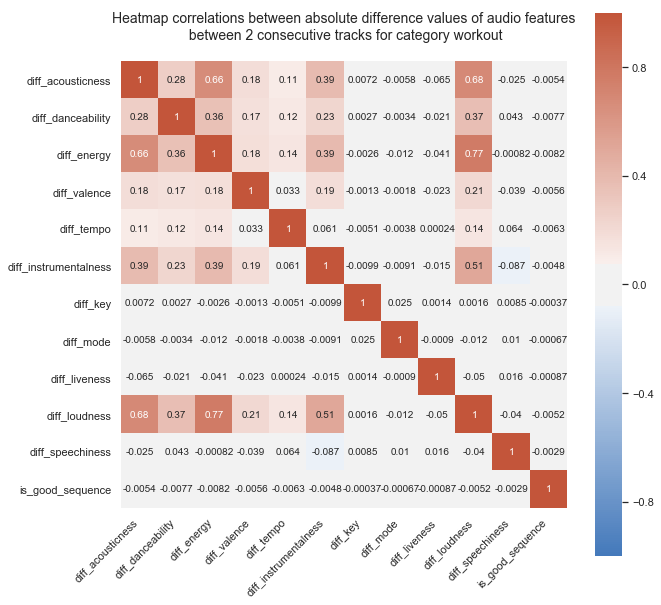

In [258]:
plt.figure(figsize=(10,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Heatmap correlations between absolute difference values of audio features" 
             +"\n between 2 consecutive tracks for category "+category+"\n", fontsize = 14);

## Applying logit

In [259]:
import patsy
import statsmodels.api as sm

endog, exog = patsy.dmatrices('is_good_sequence ~ diff_acousticness + diff_danceability + diff_energy + diff_valence +'+
                              'diff_tempo + diff_instrumentalness + diff_liveness+ diff_loudness + diff_speechiness +'+
                              ' C(diff_key) + C(diff_mode)',
                              data = df, return_type = 'matrix')

model=sm.Logit(endog,exog)
res=model.fit()


Optimization terminated successfully.
         Current function value: 0.002666
         Iterations 14


## Summary Logit

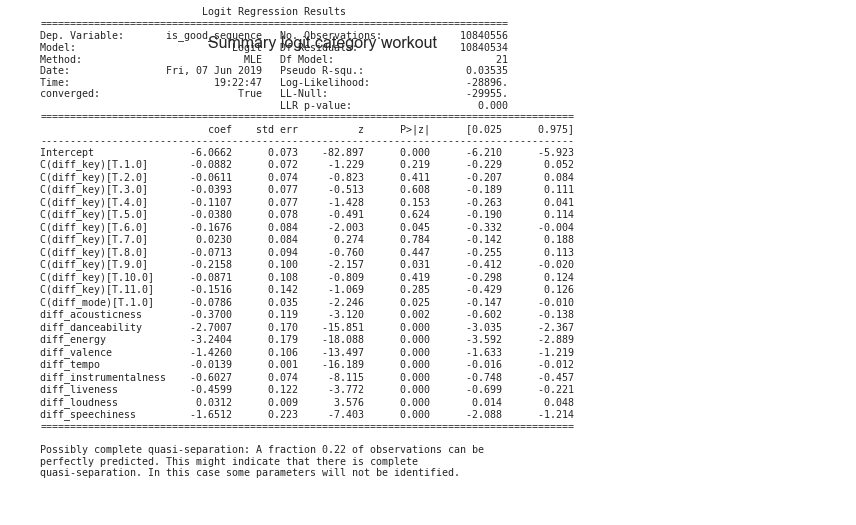

In [260]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit category '+category, {'fontsize': 16, 'horizontalalignment': 'right'})
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary_'+category+"_"+TodaysDate+'.png')

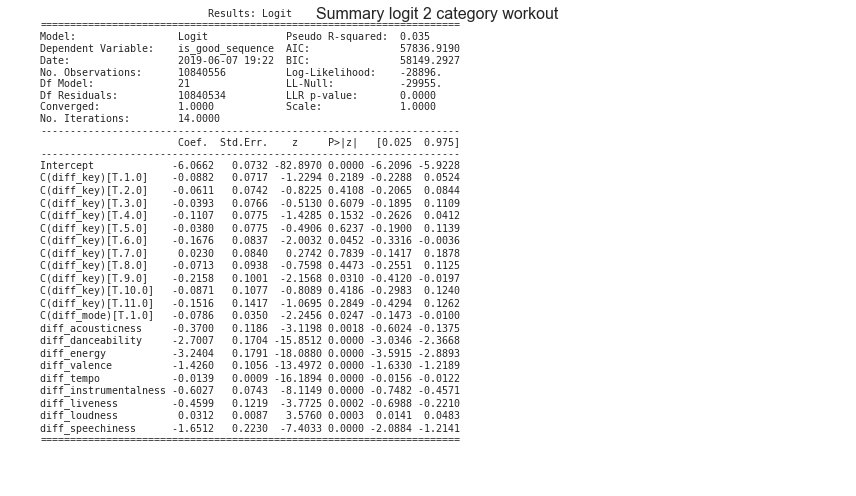

In [261]:
plt.rc('figure', figsize=(12, 7))
plt.title('Summary logit 2 category '+category+"\n\n\n\n\n\n\n\n", {'fontsize': 16, 'horizontalalignment': 'center'})
plt.text(0.01, 0.05, str(res.summary2()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig(images_folder+'logit_summary2_'+category+"_"+TodaysDate+'.png')

## Odds Ratios

In [262]:
# GETTING THE ODDS RATIOS, P-VALUE, AND 95% CI
res_odds = pd.DataFrame(np.exp(res.params), columns= ['OR'])
res_odds['p-value']= res.pvalues
res_odds[['2.5%', '97.5%']] = pd.DataFrame(np.exp(res.conf_int()))
res_odds['significant'] = res_odds['p-value'] < 0.05
res_odds.index = ['Intercept', 'C(key)[T.1.0]','C(key)[T.2.0]','C(key)[T.3.0]','C(key)[T.4.0]','C(key)[T.5.0]',
                        'C(key)[T.6.0]', 'C(key)[T.7.0]','C(key)[T.8.0]','C(key)[T.9.0]','C(key)[T.10.0]','C(key)[T.11.0]',
                       'C(mode)[T.1.0]', 'acousticness', 'danceability', 'energy', 'valence','tempo', 'instrumentalness', 
                        'liveness', 'loudness','speechiness']

res_odds

OR       p-value      2.5%     97.5%  significant
Intercept         0.002320  0.000000e+00  0.002010  0.002678         True
C(key)[T.1.0]     0.915590  2.189320e-01  0.795504  1.053805        False
C(key)[T.2.0]     0.940772  4.107786e-01  0.813395  1.088097        False
C(key)[T.3.0]     0.961452  6.079469e-01  0.827375  1.117257        False
C(key)[T.4.0]     0.895206  1.531606e-01  0.769054  1.042051        False
C(key)[T.5.0]     0.962684  6.237388e-01  0.826980  1.120656        False
C(key)[T.6.0]     0.845687  4.516111e-02  0.717775  0.996393         True
C(key)[T.7.0]     1.023311  7.839281e-01  0.867910  1.206537        False
C(key)[T.8.0]     0.931225  4.473500e-01  0.774878  1.119119        False
C(key)[T.9.0]     0.805863  3.102150e-02  0.662334  0.980495         True
C(key)[T.10.0]    0.916547  4.185555e-01  0.742095  1.132010        False
C(key)[T.11.0]    0.859346  2.848517e-01  0.650912  1.134523        False
C(mode)[T.1.0]    0.924370  2.473276e-02  0.863049  0.990048         True
acousticness      0.690744  1.809963e-03  0.547482  0.871495         True
danceability      0.067159  1.378997e-56  0.048093  0.093785         True
energy            0.039149  3.959066e-73  0.027557  0.055617         True
valence           0.240279  1.625309e-41  0.195338  0.295558         True
tempo             0.986213  5.989668e-59  0.984556  0.987872         True
instrumentalness  0.547348  4.861812e-16  0.473202  0.633111         True
liveness          0.631348  1.616261e-04  0.497164  0.801747         True
loudness          1.031719  3.488743e-04  1.014212  1.049528         True
speechiness       0.191816  1.328752e-13  0.123889  0.296986         True